# simple synthetic inversion

Here we try to recover the true Layer 1 topography with a gravity inversion. We start with the forward gravity of Layer 1 as the observed gravity, then down-sample this gravity to represent a coarser gravity survey, and final, repeate these steps with a regional component including in the observed gravity. The regional component is the forward gravity of Layer 2. 

We also explore adding gaussian noise to these gravity data. 

The starting (low-resolution) Layer 1 topography has been created through the random sampling and gridding of 30 points. In an Antarctic setting, these points represent single seismic survey locations which measure the elevation of Layer 1. 

import packages

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic, regional
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os
import pathlib
import string
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.contrib.itertools import product
from tqdm.autonotebook import tqdm
import pickle
import optuna
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sns.set_theme()

# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [ ]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2.zarr").z

starting_layer1 = xr.open_zarr("../synthetic_data/synthetic_lowres_layer1.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
layer2 = layer2.astype(np.float64)
starting_layer1 = starting_layer1.astype(np.float64)

print(utils.get_grid_info(layer1))
print(utils.get_grid_info(layer2))
print(utils.get_grid_info(starting_layer1))
starting_layer1

## gravity data
* full resolution forward gravity of Layer 1

In [ ]:
# full resolution gravity point data
grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Set region and parameters

Use the same regions and parameters as `synthetic_model_2layer.ipynb`

In [4]:
layer_spacing, buffer_region, _, _, registration = utils.get_grid_info(layer2)

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 1e3

inversion_region = utils.alter_region(
    buffer_region,
    zoom=6e3,
)[0]

# set density contrast
density = 2300 - 1024

print(f"spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

spacing: 1000.0m
registration: g
inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-6000.0, 86000.0, -6000.0, 66000.0]


# Prep data

## grav data

In [5]:
# full_res_grav = inv_utils.prep_grav_data(
#     grav,
#     region=inversion_region,
#     input_grav_name="Surface1",
#     input_coord_names=("easting", "northing", "upward"),
# )

# print(f"full resolution gravity: {len(full_res_grav)} points")

# print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

## constraint points

In [6]:
# load constraint points into a dataframe
constraints_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraints = utils.points_inside_region(
    constraints_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraints)}")
constraints.head()

bathymetry control points:30


easting      northing      upward
0  33693.672357   7507.422695 -730.639763
1  56744.661502  25582.027000 -684.765417
2   2008.692486  55641.813688 -547.650670
3  24977.275520  31857.255958 -732.211495
4  13153.447702  40745.118381 -788.180820

## plot inputs

In [7]:
# # grid the observed gravity
# Gobs = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs

# # plot observed gravity
# fig = maps.plot_grd(
#     grid=Gobs,
#     fig_height=8,
#     cmap="vik",
#     region=buffer_region,
#     title="Gravity anomaly",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 1
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Layer 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the starting Layer 1 density contrast. This will be the input into our inversion.


## layer 1 prisms

In [8]:
# create prisms around starting layer 1
# positive densities above reference, negative below
print(f"Layer 1 density contrast: {density}kgm-3")

layer1_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer1,
    reference=starting_layer1.values.mean(),
    density=xr.where(
        starting_layer1 >= starting_layer1.values.mean(), density, -density
    ),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

Layer 1 density contrast: 1276kgm-3


## layer 1 gravity

In [9]:
# # calculate gravity of layer1
# layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
#     [layer1_prisms],
#     full_res_grav,
#     names=["layer1_prisms"],
#     remove_median=False,
#     progressbar=True,
#     plot=False,
# )

# full_res_grav["layer1_forward"] = layer1_grav_df.forward_total

# full_res_grav

## Misfit

In [10]:
# full_res_grav = inv.misfit(
#     input_grav=full_res_grav,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraints,
# )

### Save and load results

In [11]:
# full_res_grav.to_csv(
#     "../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )

In [12]:
full_res_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

full_res_grav

northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  4.895946 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.832540 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.764286 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  4.692135 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.616825 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.822520  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.821796  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.821311  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.820943  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.820536  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift    misfit  
0            7.336436    5.870426 -1.466010  
1            7.196777    5.807020 -1.389757  
2            7.053205    5.738766 -1.314439  
3            6.907357    5.666615 -1.240742  
4            6.760484    5.591305 -1.169179  
...               ...         ...       ...  
19476        0.539365    1.797000  1.257635  
19477        0.610158    1.796276  1.186118  
19478        0.680730    1.795791  1.115061  
19479        0.750859    1.795423  1.044564  
19480        0.820233    1.795015  0.974782  

[19481 rows x 10 columns]

# Constraints grid

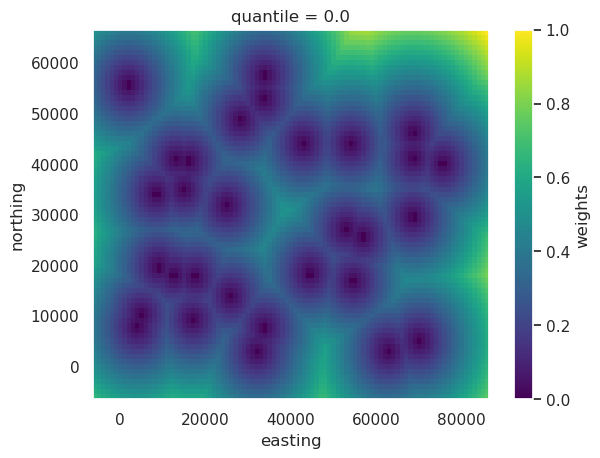

In [13]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist
starting_prisms.weights.plot()

In [14]:
# min_dist = inv_utils.normalized_mindist(constraints, starting_prisms, mindist = layer_spacing/np.sqrt(2),)

# fig = maps.plot_grd(
#     min_dist,
#     region=inversion_region,
#     fig_height=10,
#     title="Weighting grid",
#     cmap="dense",
#     hist=True,
#     cbar_yoffset=1.5,
#     cbar_unit_annot="km",
#     cbar_scale=.001,
# )

# fig.plot(
#     x = constraints.easting,
#     y = constraints.northing,
#     style = "x0.2c",
#     pen='1p',
# )

# pygmt.grd2cpt(grid = starting_prisms.weights, background="i", cmap="dense",)
# with pygmt.config(
#     FONT_ANNOT="Helvetica-Oblique",
#     MAP_ANNOT_OFFSET_PRIMARY="18p",
#     MAP_TICK_LENGTH_PRIMARY="0p", ):
#     maps.add_colorbar(fig=fig, cbar_yoffset=1.5)

# fig.show()

In [15]:
# min_dist = inv_utils.normalized_mindist(constraints, starting_prisms,)

# fig = maps.plot_grd(
#     min_dist,
#     region=inversion_region,
#     fig_height=10,
#     title="Minimum distance to constraints",
#     cmap="dense",
#     hist=True,
#     cbar_yoffset=1.5,
#     cbar_unit_annot="km",
#     cbar_scale=.001,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="18p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# fig.plot(
#     x = constraints.easting,
#     y = constraints.northing,
#     style = "x0.2c",
#     pen='1p',
# )
# fig = maps.plot_grd(
#     starting_prisms.weights,
#     region=inversion_region,
#     fig=fig,
#     origin_shift = "xshift",
#     title="Weighting grid",
#     # cbar_unit="m",
#     cmap="dense",
#     hist=True,
#     cbar_yoffset=1.5,
# )
# fig.plot(
#     x = constraints.easting,
#     y = constraints.northing,
#     style = "x0.2c",
#     pen='1p',
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="18p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# # pygmt.grd2cpt(grid = starting_prisms.weights, background="i", cmap="dense",)
# # with pygmt.config(
# #     FONT_ANNOT="Helvetica-Oblique",
# #     MAP_ANNOT_OFFSET_PRIMARY="18p",
# #     MAP_TICK_LENGTH_PRIMARY="0p", ):
# #     maps.add_colorbar(fig=fig, cbar_yoffset=1.5)

# fig.show()

# Set regional component to 0 for simple models

In [16]:
full_res_grav["reg"] = 0
full_res_grav["res"] = full_res_grav.misfit
print(full_res_grav.res.median())

full_res_grav

0.2167101669468687


northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  4.895946 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.832540 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.764286 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  4.692135 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.616825 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.822520  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.821796  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.821311  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.820943  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.820536  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift    misfit  reg       res  
0            7.336436    5.870426 -1.466010    0 -1.466010  
1            7.196777    5.807020 -1.389757    0 -1.389757  
2            7.053205    5.738766 -1.314439    0 -1.314439  
3            6.907357    5.666615 -1.240742    0 -1.240742  
4            6.760484    5.591305 -1.169179    0 -1.169179  
...               ...         ...       ...  ...       ...  
19476        0.539365    1.797000  1.257635    0  1.257635  
19477        0.610158    1.796276  1.186118    0  1.186118  
19478        0.680730    1.795791  1.115061    0  1.115061  
19479        0.750859    1.795423  1.044564    0  1.044564  
19480        0.820233    1.795015  0.974782    0  0.974782  

[19481 rows x 12 columns]

# Inversion

## Full resolution grav, no noise

In [17]:
# plotting.misfit_plotting(
#     full_res_grav,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     # points_style="c0.1c",
# )

In [18]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=100,
#     l2_norm_tolerance=0.15,
#     delta_l2_norm_tolerance=1.02,#1.01, # stop if l2-norm doesnt decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     # deriv_type = "prisms",
#     solver_type = "scipy least squares",
#     # solver_type = "verde least squares",
#     solver_damping = 10**-2,
#     plot_convergence=True,
# )

# # with inv_utils.HiddenPrints():
# results = inv.inversion_RMSE(
#     input_grav=full_res_grav[full_res_grav.test==False],
#     inversion_region=inversion_region,
#     true_surface = layer1,
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     plot=True,
#     plot_type="xarray",
#     # robust=True,
#     **kwargs,
# )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     plot_iter_results=True,
#     plot_topo_results=True,
#     plot_grav_results=True,
#     iters_to_plot=4,
#     grav_spacing=grav_spacing,
#     constraints=constraints,
# )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

### Optimize only for damping

#### with optuna

In [29]:
# # set kwargs for inversion
# inversion_kwargs = dict(
#     input_grav_column="Gobs_shift",
#     max_iterations=100,
#     l2_norm_tolerance=0.15, # sqrt(RMS)=l2-norm, set to sqrt(noise)
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesn't decrease by at least 2%
#     weights_after_solving = True,
#     # deriv_type = "annulus",
#     # deriv_type = "prisms",
#     solver_type = "scipy least squares",
#     inversion_region = inversion_region,
# )

# study_name = f"synthetic_simple_optimization_damping"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# # remove if exists
# for p in pathlib.Path(".").glob(f"{fname}*"):
#     pathlib.Path(p).unlink(missing_ok=True)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # define the objective function
# objective_func = optimization.CV_inversion(
#     training_data = full_res_grav[full_res_grav.test==False],
#     testing_data = full_res_grav[full_res_grav.test==True],
#     fname = results_fname,
#     starting_prisms = starting_prisms,
#     true_surface = layer1,
#     damping_limits = [-5, -1],  # damping = 10^damping_limit
#     damping_step = .1,
#     **inversion_kwargs,
# )

# # define search space if using GridSampler
# search_space = {"damping": [-5, -4, -3, -2, -1],}

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     direction="minimize",
#     sampler=optuna.samplers.GridSampler(search_space),
#     load_if_exists=True,
# )

# # run the optimization
# study, study_df = optimization.optuna_parallel(
#     study_name=study_name,
#     study_storage=storage,
#     objective = objective_func,
#     n_trials=len(search_space["damping"]),
#     maximize_cpus=True,
#     # parallel=False,
# )

# # set number of CV runs
# n_trials = 10

# # create study
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="BoTorch")
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=0),
#         load_if_exists=True,
#     )
# # run the optimization
# study, study_df = optimization.optuna_parallel(
#     study_name=study_name,
#     study_storage=storage,
#     objective = objective_func,
#     n_trials=n_trials,
#     maximize_cpus=True,
#     # parallel=False,
# )
# study_df = study.trials_dataframe()

In [49]:
# study_name = f"synthetic_simple_optimization_damping"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # load and plot past study
# study = optuna.load_study(
#     study_name=study_name,
#     storage=storage,
# )
# print("Best damping:", study.best_params)
# print("Best trial:", study.best_trial.number)
# print("Best score:", study.best_trial.value)
# # load best inversion's results
# with open(f"{results_fname}_trial_{study.best_trial.number}_results.pickle", 'rb') as f:
#     results = pickle.load(f)

# # plotting.plot_optuna_inversion_figures(
# #     study,
# #     target_names=["CV Score"],
# #     # include_duration=True,
# # #     plot_history=False,
# #     plot_edf=False,
# # )
# study_df = study.trials_dataframe().sort_values(by="value")
# study_df.head()

In [48]:
# plotting.plot_parameter_cv(study_df.value, 10**study_df.params_damping,
#     logx=True,
#     # logy=True,
#     param_name = "Damping", )

In [ ]:
# print(study.best_params)

# _ = inv.inversion_RMSE(
#     results = results,
#     true_surface = layer1,
#     inversion_region = inversion_region,
#     constraints = constraints,
#     plot=True,
#     # plot_type = "xarray",
#     points_style="+.2c",
#     # robust=True,#False,
# )

In [ ]:
# _ = plotting.plot_inversion_results(
#         results["grav_results"],
#         results["prism_results"],
#         results["params"],
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {results['rmse']}")
# print(f"constraints RMSE: {results['constraints_rmse']}")

In [ ]:
# plotting.plot_inversion_results_profile(
#     grav_results = results["grav_results"],
#     prism_results = results["prism_results"],
#     input_forward_column="layer1_forward",
#     constraints = constraints,
#     true_surface = layer1,
#     start = [inversion_region[0], 30e3],
#     stop = [inversion_region[1], 30e3],
#     map_buffer = 0.1,
#     layers_legend_loc="JTR+jTR",
#     data_legend_loc="JTR+jTR",
# )

#### grid search

Damping values: [0.0001     0.00021544 0.00046416 0.001      0.00215443 0.00464159
 0.01       0.02154435 0.04641589 0.1       ]
Best score: 0.020735259152960095
Best damping: 0.004641588833612777


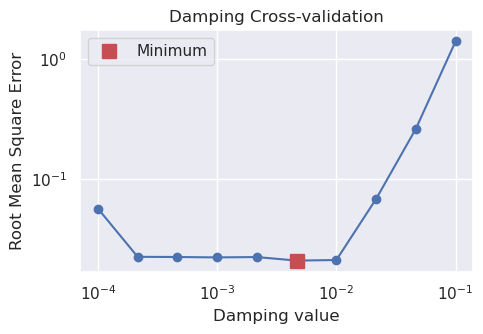

In [23]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    # deriv_type = "prisms",
    solver_type="scipy least squares",
    constraints=constraints,
)

fname = "../synthetic_data/synthetic_simple_damping_CV_no_weight_exponent"
# fname = "../synthetic_data/synthetic_simple_damping_CV_prisms"
dampings = np.logspace(-4, -1, 10)
print(f"Damping values: {dampings}")

# scores, rmses = inv.inversion_optimal_parameters(
#     training_data= full_res_grav[full_res_grav.test==False],
#     testing_data = full_res_grav[full_res_grav.test==True],
#     parameter_values = dampings,
#     function = inv.inversion_damping_MSE,
#     plot = False,
#     plot_grids = True,
#     results_fname=fname,
#     progressbar=True,
#     true_surface=layer1,
#     inversion_region=inversion_region,
#     **kwargs,
# )

# # put scores and damping values into dict
# CV_results = dict(
#     scores=scores, dampings=dampings, rmses=rmses)

# # remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

# # save scores and dampings to pickle
# with open(f"{fname}.pickle", 'wb') as f:
#     pickle.dump(CV_results, f)

# load scores and dampings from pickle
with open(f"{fname}.pickle", "rb") as f:
    CV_results = pickle.load(f)

best = np.argmin(CV_results["scores"])
print("Best score:", CV_results["scores"][best])
print("Best damping:", CV_results["dampings"][best])

# get best inversion result of each set
with open(f"{fname}_trial_{best}.pickle", "rb") as f:
    inv_result = pickle.load(f)

plotting.plot_parameter_cv(
    CV_results["scores"],
    CV_results["dampings"],
    logx=True,
    logy=True,
    param_name="Damping",
)

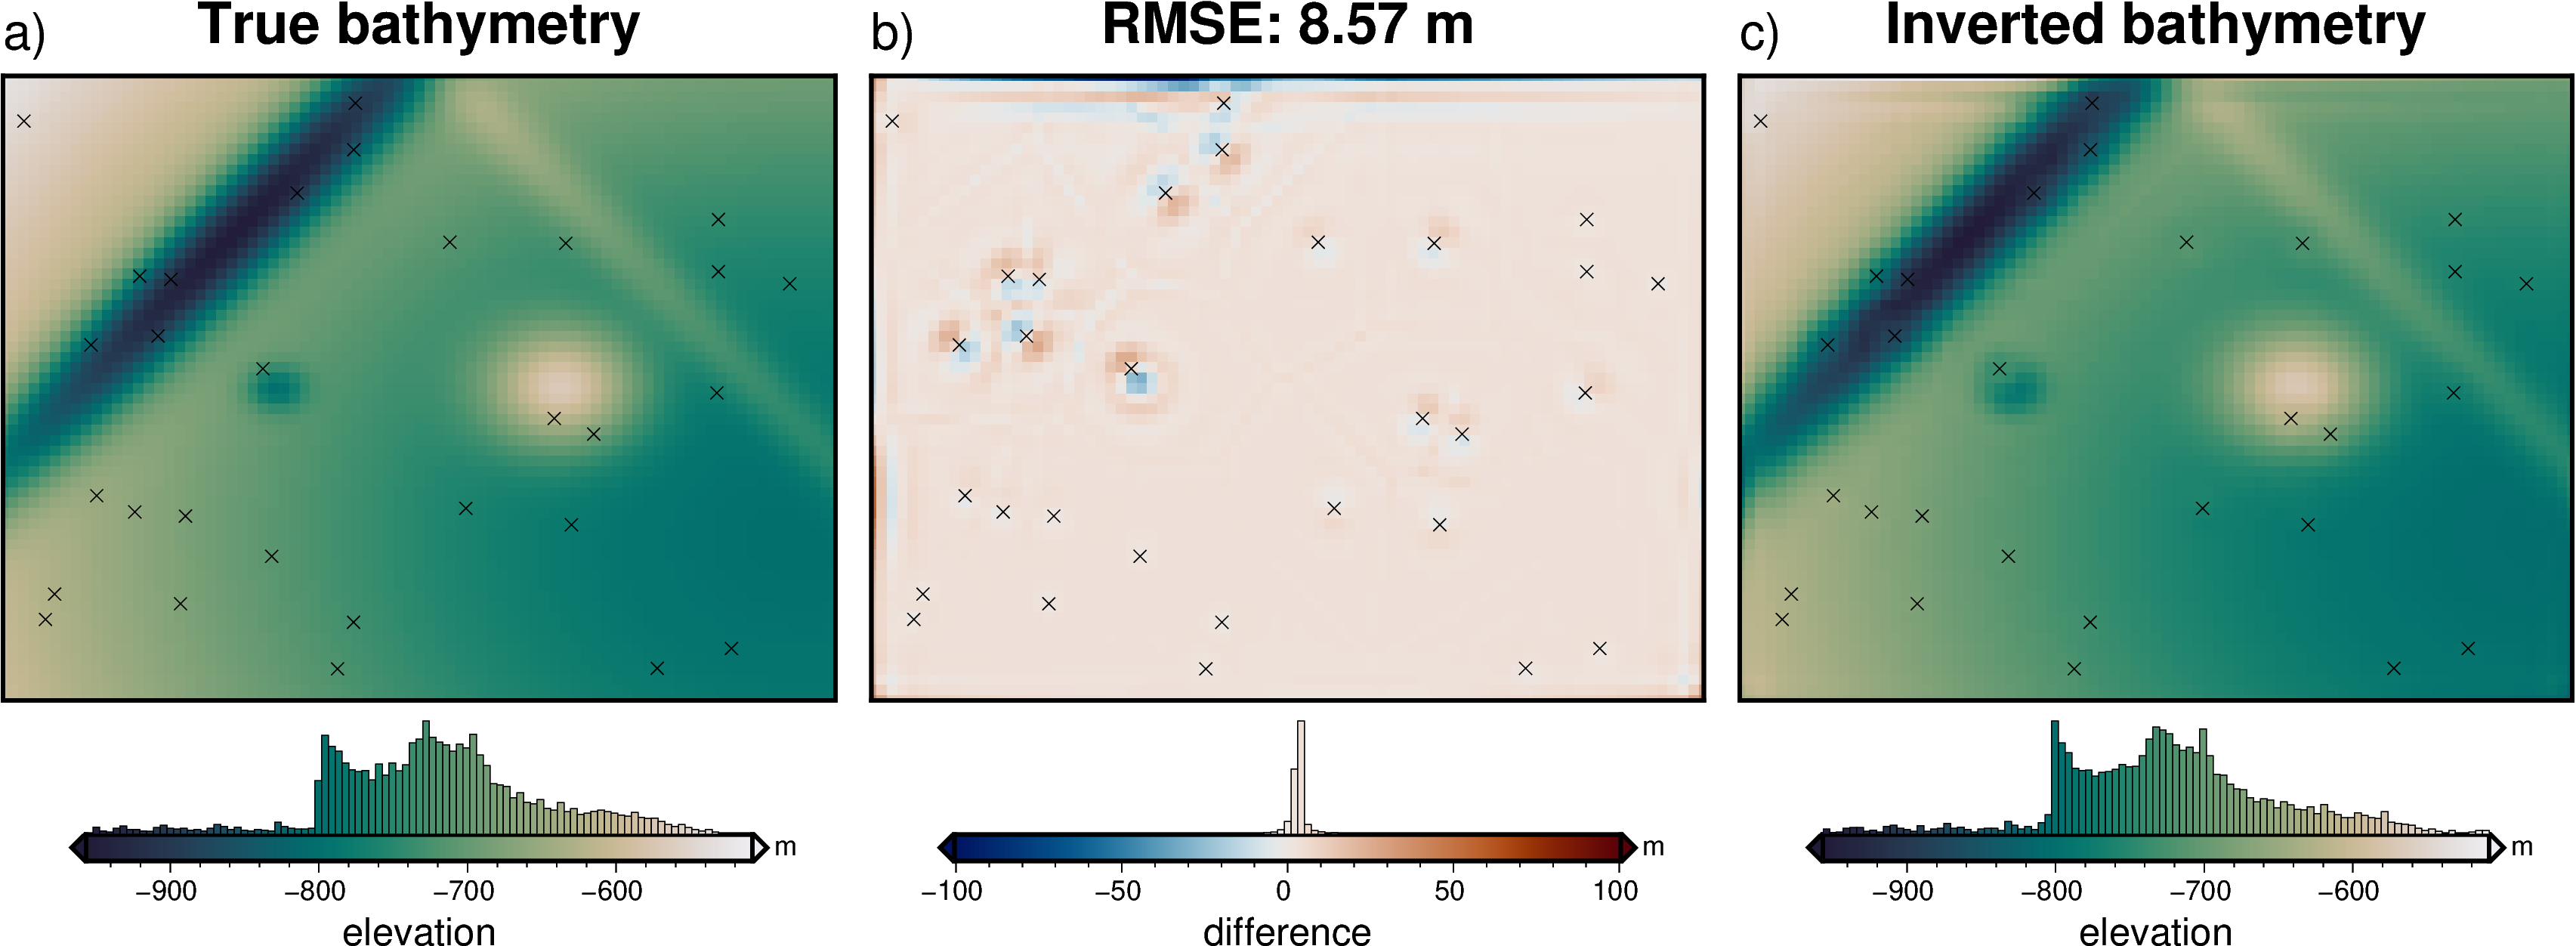

RMSE: 8.572737081012212
constraints RMSE: None


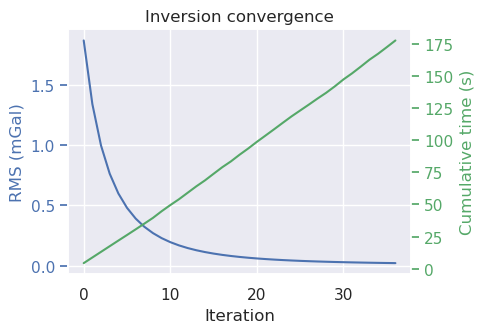

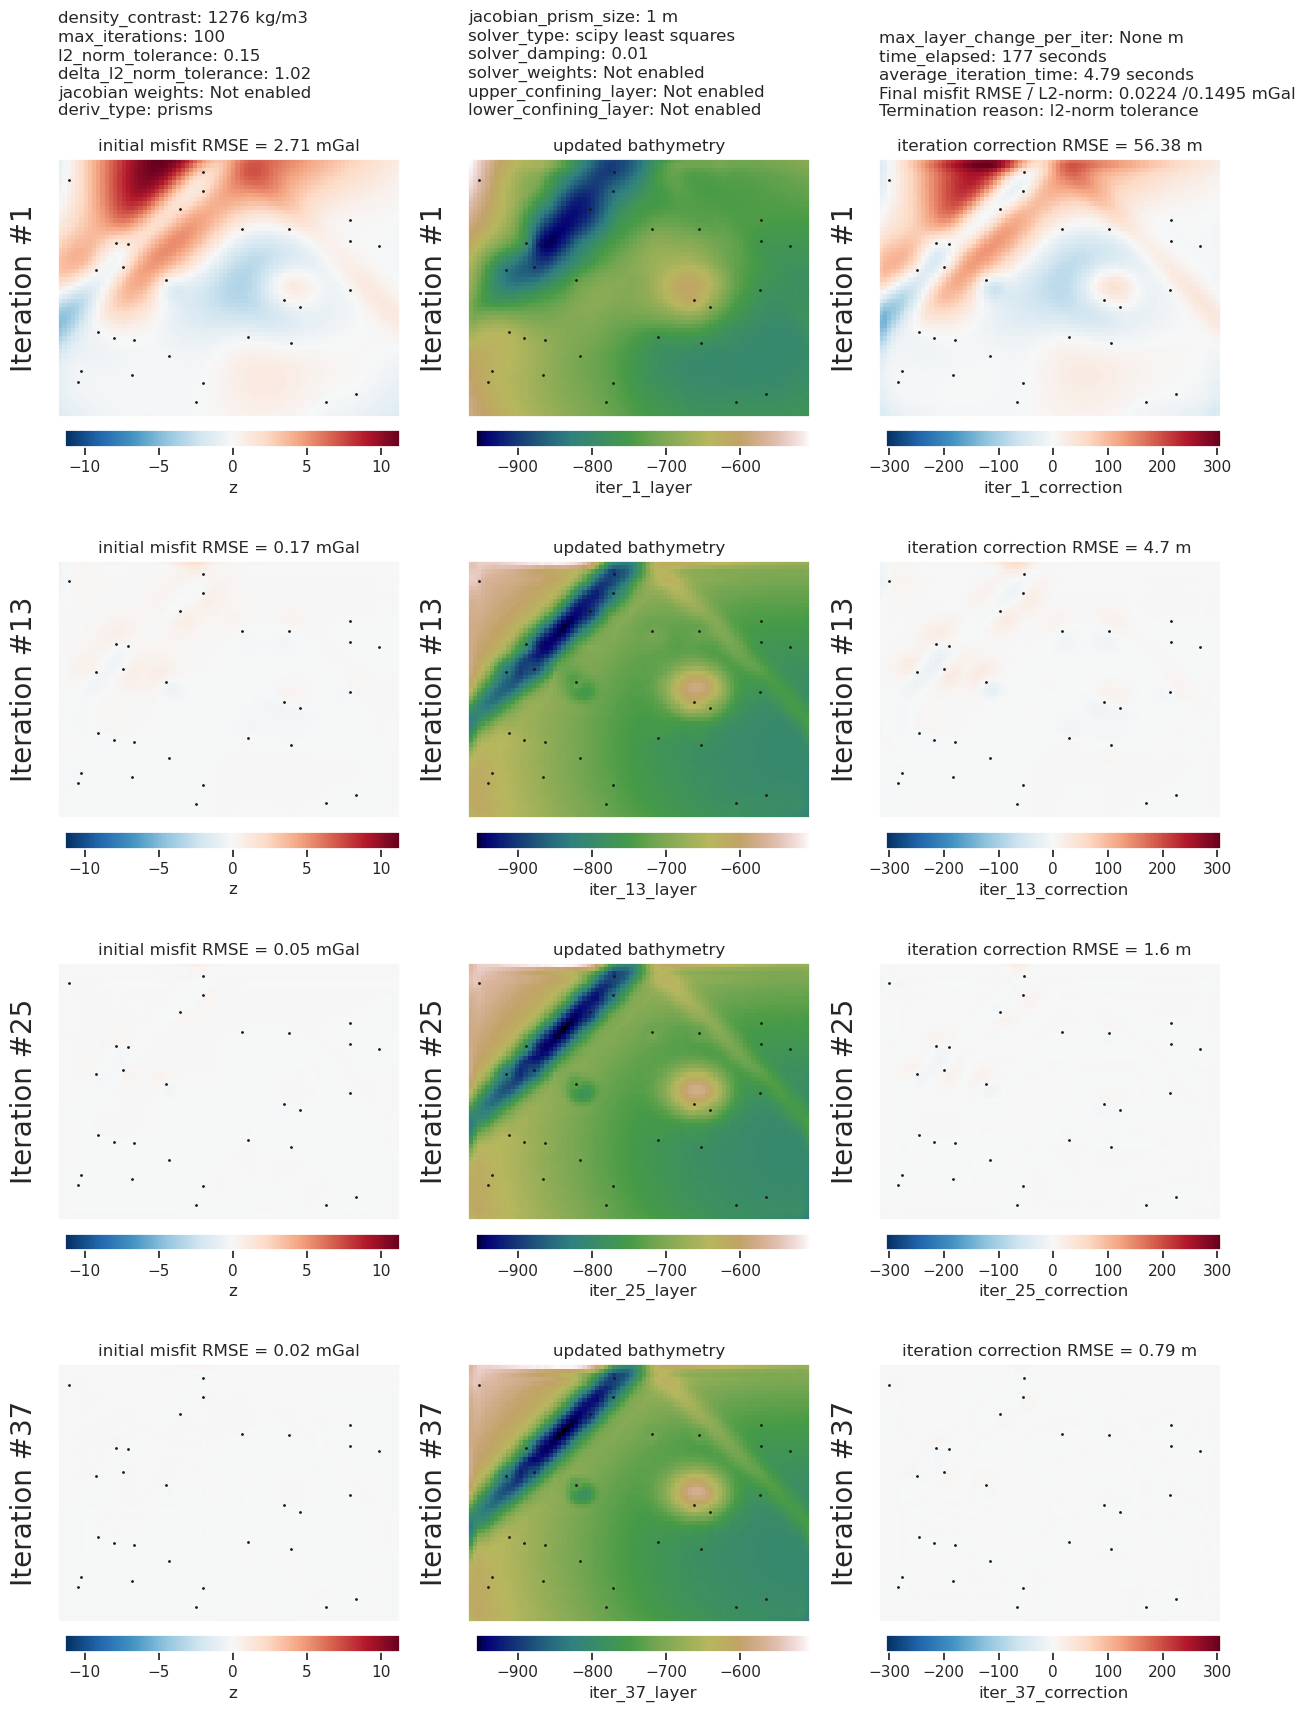

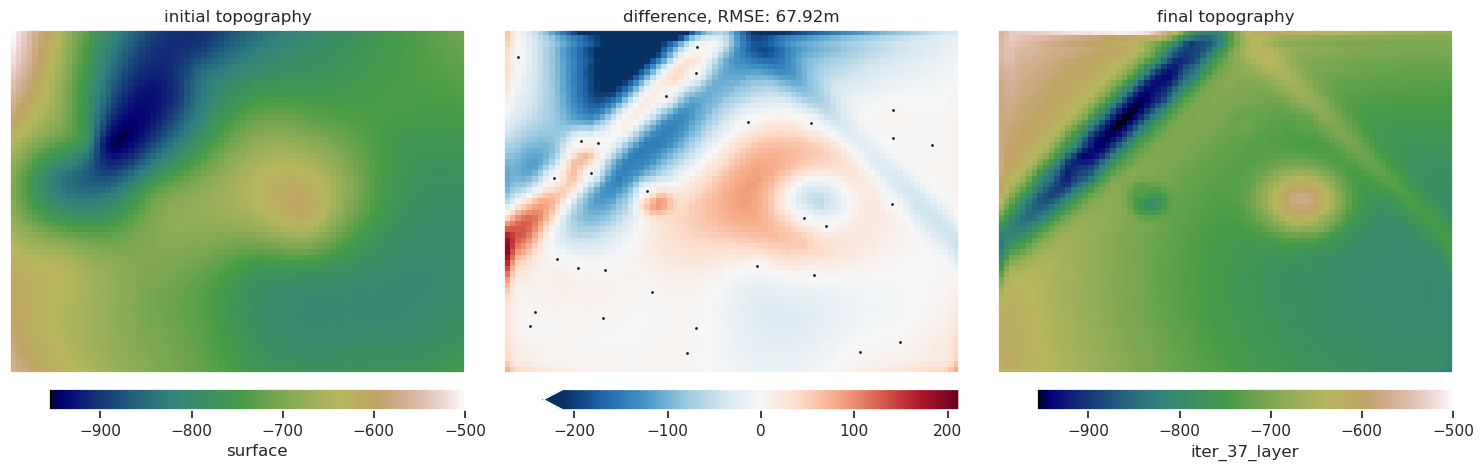

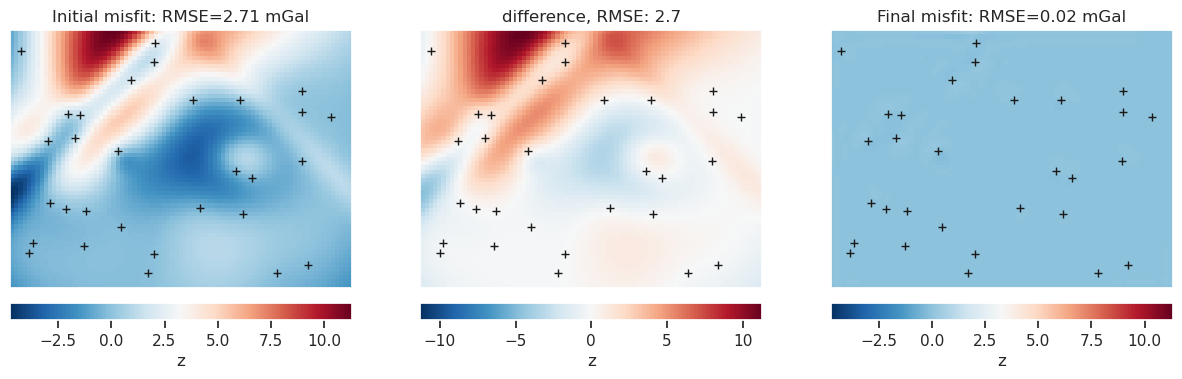

In [27]:
# with inv_utils.HiddenPrints():
#     _ = inv.inversion_RMSE(
#         results=inv_result,
#         input_grav=full_res_grav[full_res_grav.test==False],
#         inversion_region=inversion_region,
#         true_surface = layer1,
#         plot=True,
#         plot_type="pygmt",
#         label_offset = "j0c/.2c",
#         **kwargs,
#     )

# plotting.plot_convergence(
#     inv_result[2],
#     iter_times=inv_result[3]["iter_times"])

# _ = plotting.plot_inversion_results(
#         inv_result[2],
#         inv_result[1],
#         inv_result[3],
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {inv_result[0]}")
# print(f"constraints RMSE: {inv_result[-1]}")

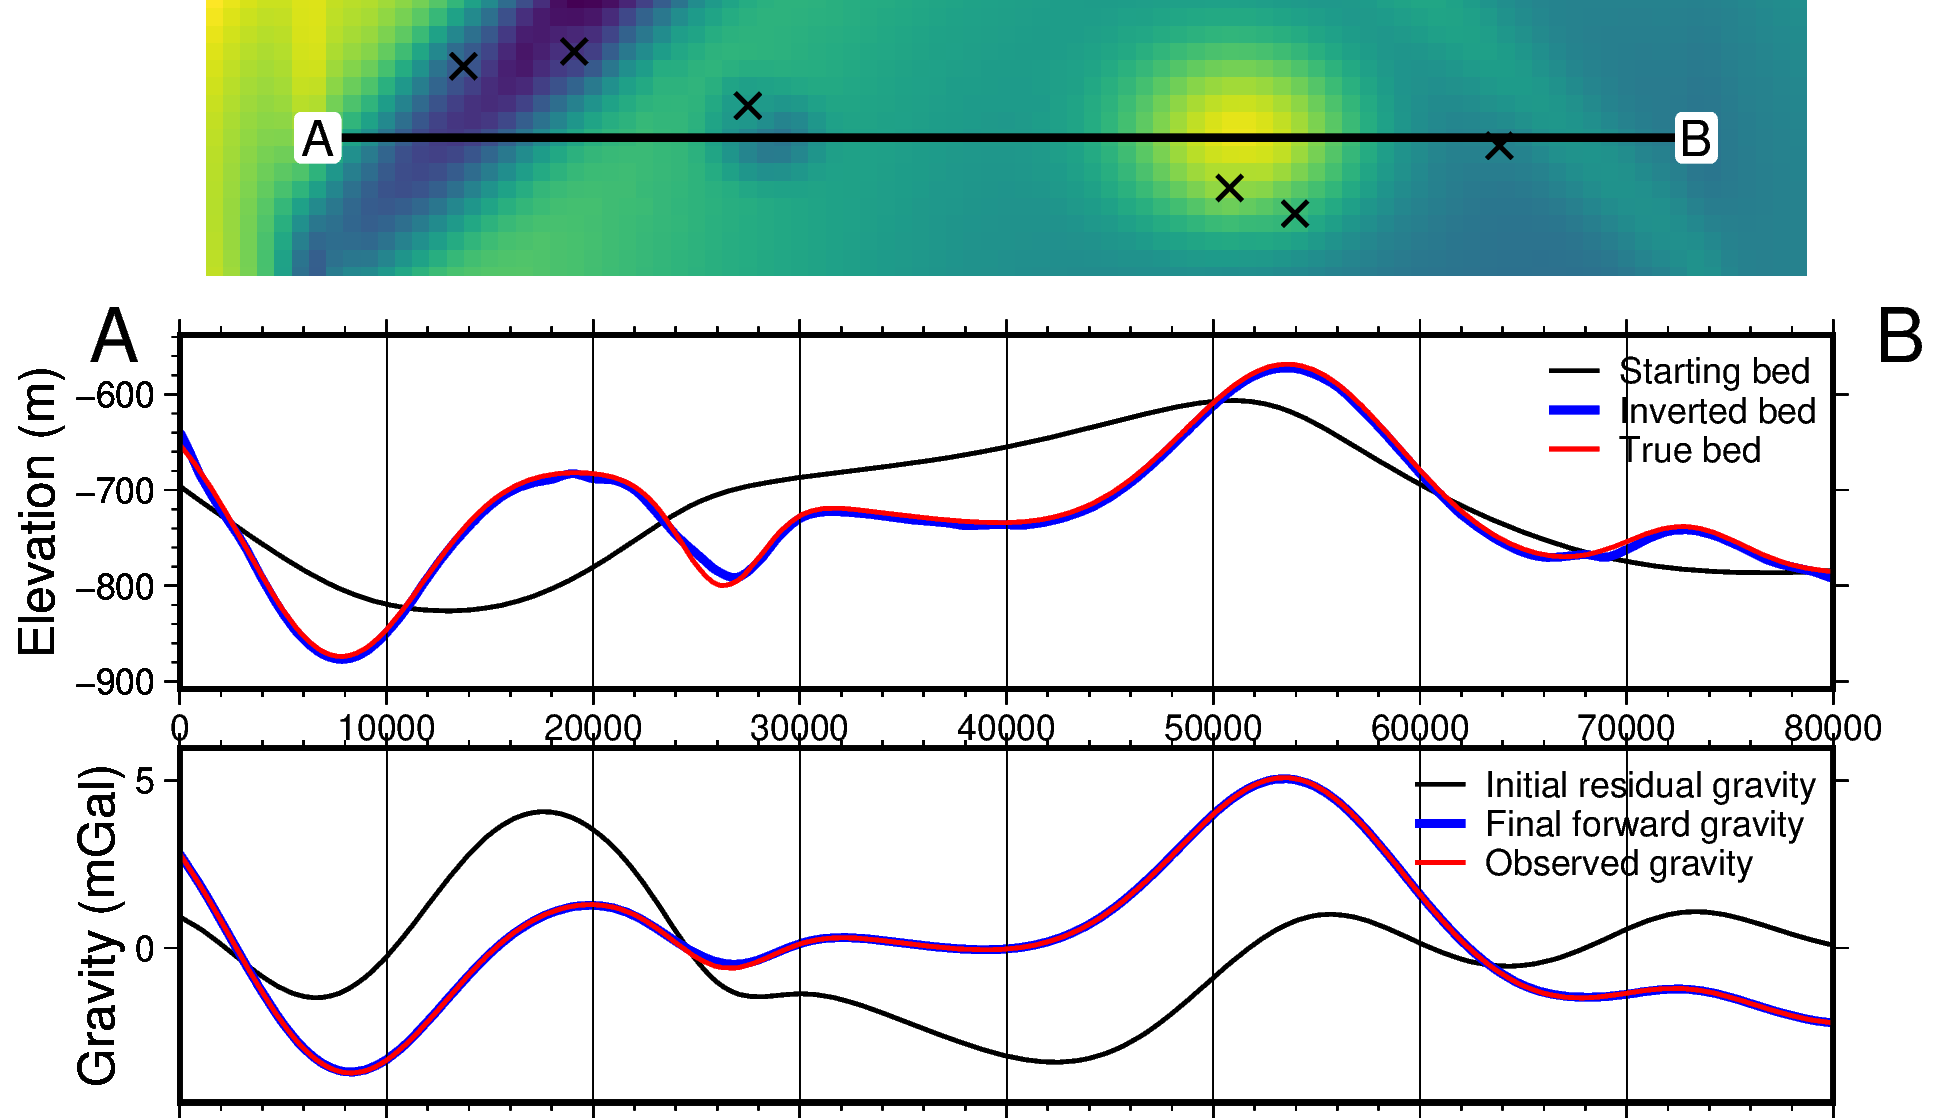

In [30]:
plotting.plot_inversion_results_profile(
    inv_result[1],
    inv_result[2],
    input_forward_column="layer1_forward",
    constraints=constraints,
    true_surface=layer1,
    start=[inversion_region[0], 30e3],
    stop=[inversion_region[1], 30e3],
    map_buffer=0.1,
    subplot_orientation="vertical",
    data_legend_loc="jTR+o0c",
    layers_legend_loc="jTR+o0c",
)

### Optimize on damping and weights grid exponent

In [ ]:
# # set kwargs for inversion
# inversion_kwargs = dict(
#     input_grav_column="Gobs_shift",
#     max_iterations=100,
#     l2_norm_tolerance=0.15, # sqrt(RMS)=l2-norm, set to sqrt(noise)
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesn't decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     inversion_region = inversion_region,
# )

# # set number of CV runs for each method
# n_trials = 40

# study_name = f"synthetic_simple_CV_optimization"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# # remove if exists
# for p in pathlib.Path(".").glob(f"{fname}*"):
#     pathlib.Path(p).unlink(missing_ok=True)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # create study
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="BoTorch")
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#     )
# # define the objective function
# objective_func = optimization.CV_inversion(
#     training_data = full_res_grav[full_res_grav.test==False],
#     testing_data = full_res_grav[full_res_grav.test==True],
#     fname = results_fname,
#     starting_prisms = starting_prisms,
#     true_surface = layer1,
#     damping_limits = [-4, -1],  # damping = 10^damping_limit
#     damping_step = .1,
#     weights_exponent_limits = [.1, 1],
#     weights_exponent_step = .01,
#     layer_spacing = layer_spacing,
#     constraints = constraints,
#     **inversion_kwargs,
# )
# # run the optimization
# study, study_df = optimization.optuna_parallel(
#     study_name=study_name,
#     study_storage=storage,
#     objective = objective_func,
#     n_trials=n_trials,
#     maximize_cpus=True,
#     parallel=True,
# )

In [100]:
# study_name = f"synthetic_simple_CV_optimization"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # load and plot past study
# study = optuna.load_study(
#     study_name=study_name,
#     storage=storage,
# )
# print(study.best_params)
# print(study.best_trial.number)

# # load best inversion's results
# with open(f"{results_fname}_trial_{study.best_trial.number}_results.pickle", 'rb') as f:
#     results = pickle.load(f)

# # plotting.plot_optuna_inversion_figures(
# #     study,
# #     target_names=["CV Score"],
# #     include_duration=True,
# # #     plot_history=False,
# #     plot_edf=False,
# # )
# study_df = study.trials_dataframe().sort_values(by="value")
# study_df.head()

In [97]:
# fig = make_subplots(rows=1, cols=3, subplot_titles=("a)","b)","c)"))

# # subplot a
# fig.add_trace(plotting.combined_importance(
#     study,
#     target_names=[""]
# ).data[0], row=1, col=1)

# # subplot b
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[0], row=1, col=2)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["damping"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 2
# )

# # subplot c
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[1], row=1, col=3)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["weights_exponent"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 3
# )

# fig['layout']['xaxis']['title']='Importance'
# fig['layout']['xaxis2']['title']='Damping'
# fig['layout']['xaxis3']['title']='Weights grid exponent'
# fig['layout']['yaxis2']['title']='Score (mGal)'
# fig['layout']['yaxis3']['title']='Score (mGal)'

# fig.update_layout(
#     showlegend=False,
#     # yaxis2_range=[-.02, .2], yaxis3_range=[-.02, .2],
#     height=400, width=1200
# )

# fig.show()
# fig.write_image("chp3_simple_optimization.png")

In [98]:
# print(study.best_params)

# _ = inv.inversion_RMSE(
#     results = results,
#     true_surface = layer1,
#     inversion_region = inversion_region,
#     constraints = constraints,
#     plot=True,
#     # plot_type = "xarray",
#     # points_style="+.2c",
#     # robust=True,#False,
# )

In [99]:
# _ = plotting.plot_inversion_results(
#         results["grav_results"],
#         results["prism_results"],
#         results["params"],
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {results['rmse']}")
# print(f"constraints RMSE: {results['constraints_rmse']}")

## Full resolution grav with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [51]:
# # contaminate with noise
# full_res_grav_noise = full_res_grav.copy()
# full_res_grav_noise["Gobs"] = synthetic.contaminate(
#     full_res_grav_noise.Gobs,
#     stddev=0.02,
#     percent=True,
#     seed=0,
# )
# # DC shift and calculate misfit
# full_res_grav_noise = inv.misfit(
#     input_grav=full_res_grav_noise,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraints,
# )
# # set regional to 0
# full_res_grav_noise["reg"] = 0
# full_res_grav_noise["res"] = full_res_grav_noise.misfit

# full_res_grav_noise

Standard deviation used for noise: [0.16382499594057567]
DC shifted observed gravity by -1.01mGal to match forward gravity.


northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  5.185691 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.898845 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.925377 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  5.059999 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.923527 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.638063  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.922292  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.892272  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.965702  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.989985  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift  reg       res    misfit  
0            7.336436    6.193178    0 -1.143257 -1.143257  
1            7.196777    5.906332    0 -1.290444 -1.290444  
2            7.053205    5.932865    0 -1.120340 -1.120340  
3            6.907357    6.067486    0 -0.839871 -0.839871  
4            6.760484    5.931015    0 -0.829469 -0.829469  
...               ...         ...  ...       ...       ...  
19476        0.539365    1.645550    0  1.106185  1.106185  
19477        0.610158    1.929780    0  1.319622  1.319622  
19478        0.680730    1.899759    0  1.219029  1.219029  
19479        0.750859    1.973189    0  1.222330  1.222330  
19480        0.820233    1.997473    0  1.177239  1.177239  

[19481 rows x 12 columns]

In [ ]:
# plotting.misfit_plotting(
#     full_res_grav_noise,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

In [32]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=100,
#     l2_norm_tolerance=0.4,
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesnt decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     # deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 0.01,
#     plot_convergence=True,
# )

# with inv_utils.HiddenPrints():
#     results = inv.inversion_RMSE(
#         input_grav=full_res_grav_noise[full_res_grav_noise.test==False],
#         inversion_region=inversion_region,
#         true_surface = layer1,
#         constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#         plot=True,
#         plot_type="xarray",
#         **kwargs,
#     )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

### Optimize only for damping

Best score: 0.18686020500575395
Best damping: 0.01


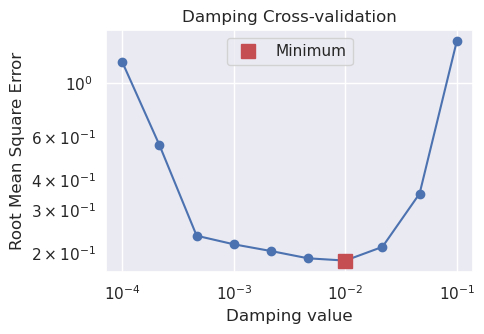

In [31]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.4,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    # deriv_type = "prisms",
    solver_type="scipy least squares",
    constraints=constraints,
)

fname = "../synthetic_data/synthetic_simple_noise_damping_CV_no_weight_exponent"
# fname = "../synthetic_data/synthetic_simple_noise_damping_CV_prisms"
dampings = np.logspace(-4, -1, 10)
# print(f"Damping values: {dampings}")

# scores, rmses = inv.inversion_optimal_parameters(
#     training_data= full_res_grav_noise[full_res_grav_noise.test==False],
#     testing_data = full_res_grav_noise[full_res_grav_noise.test==True],
#     parameter_values = dampings,
#     function = inv.inversion_damping_MSE,
#     plot = False,
#     plot_grids = True,
#     results_fname=fname,
#     progressbar=True,
#     true_surface=layer1,
#     inversion_region=inversion_region,
#     **kwargs,
# )

# # put scores and damping values into dict
# CV_results = dict(
#     scores=scores, dampings=dampings, rmses=rmses)

# # remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

# # save scores and dampings to pickle
# with open(f"{fname}.pickle", 'wb') as f:
#     pickle.dump(CV_results, f)

# load scores and dampings from pickle
with open(f"{fname}.pickle", "rb") as f:
    CV_results = pickle.load(f)

best = np.argmin(CV_results["scores"])
print("Best score:", CV_results["scores"][best])
print("Best damping:", CV_results["dampings"][best])

# get best inversion result of each set
with open(f"{fname}_trial_{best}.pickle", "rb") as f:
    inv_result = pickle.load(f)

plotting.plot_parameter_cv(
    CV_results["scores"],
    CV_results["dampings"],
    logx=True,
    logy=True,
    param_name="Damping",
)

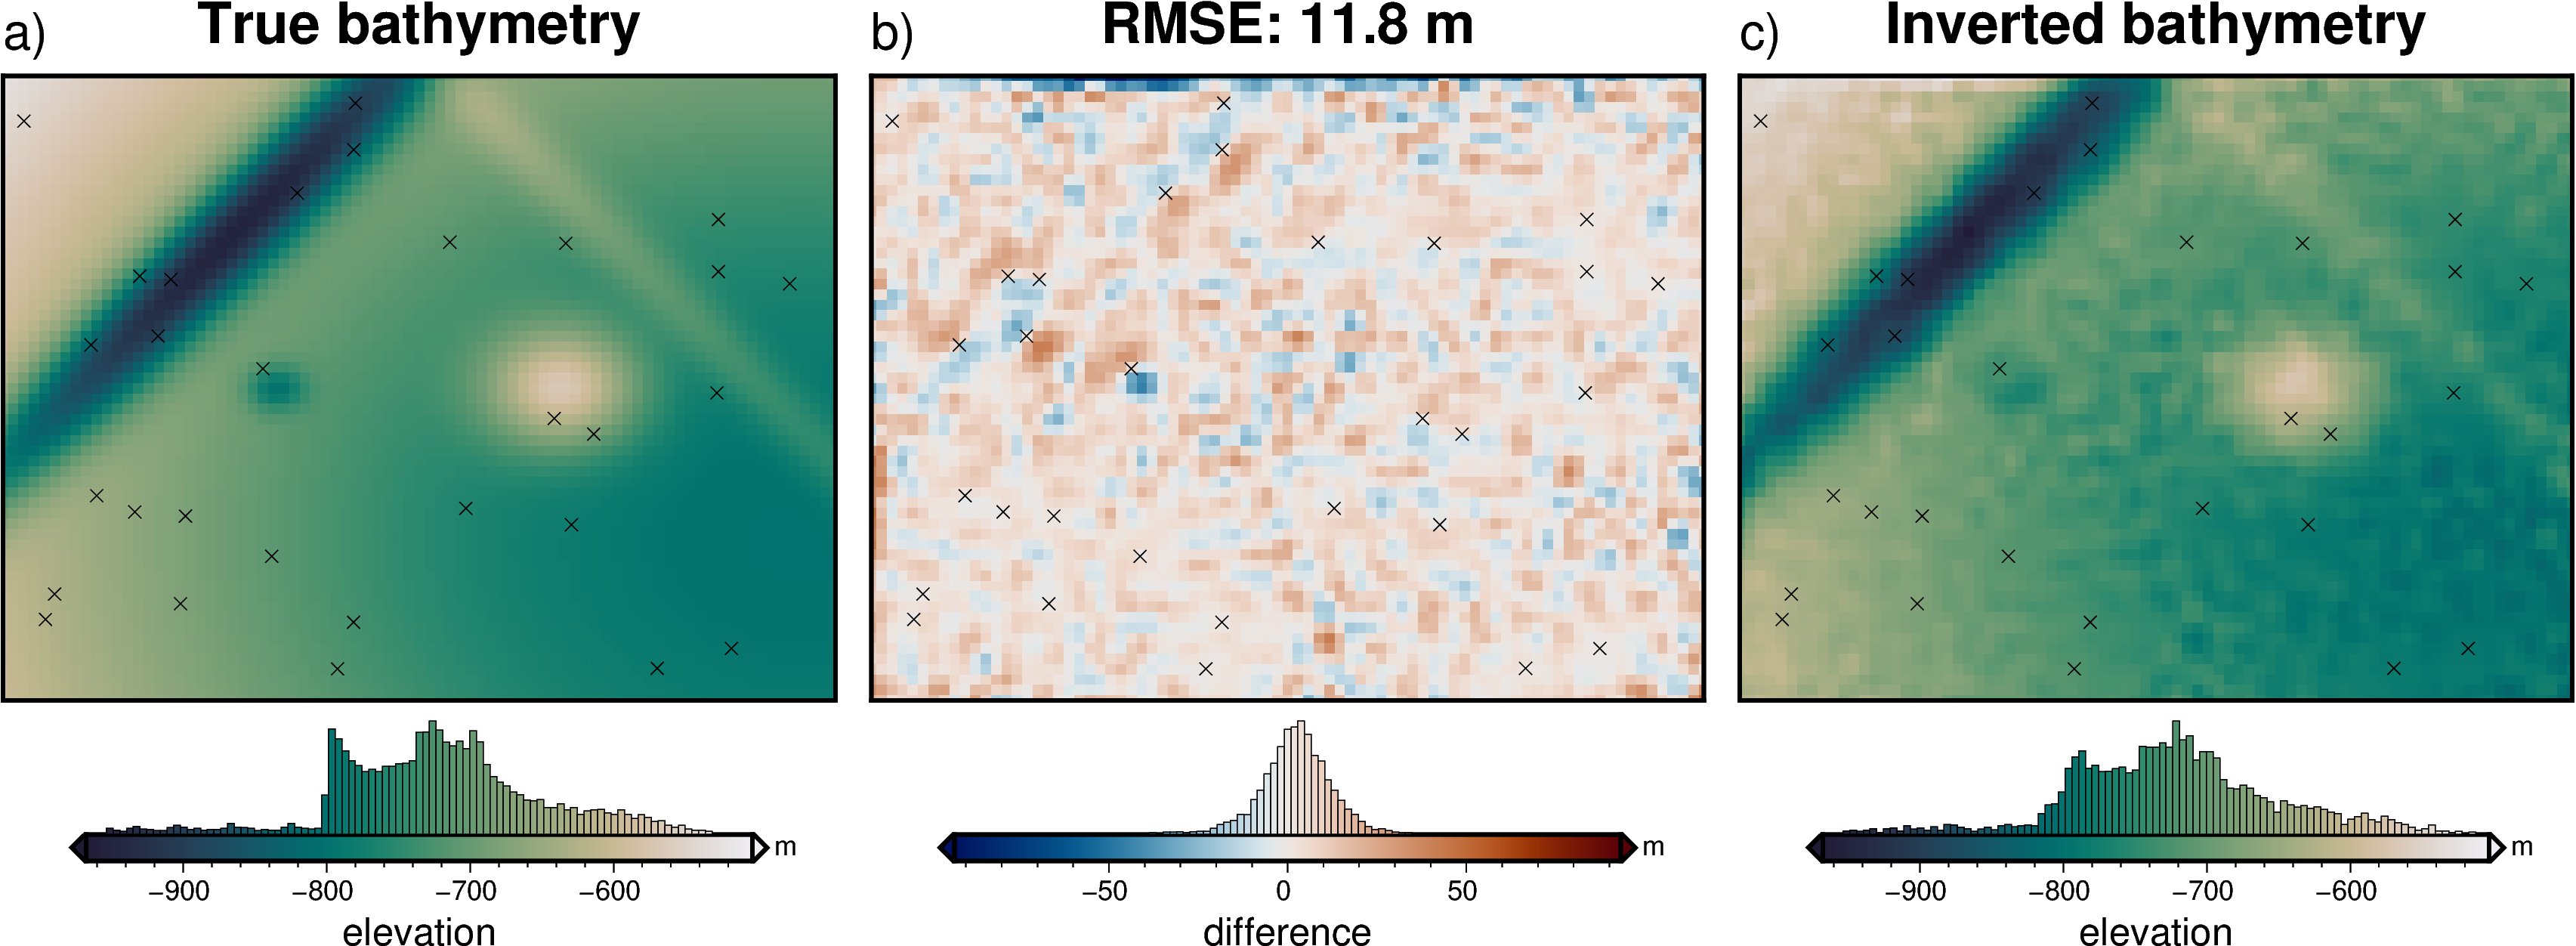

RMSE: 11.80219778337163
constraints RMSE: None


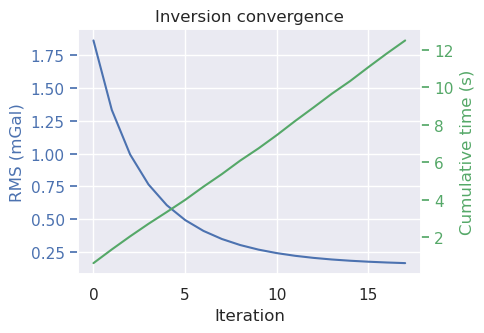

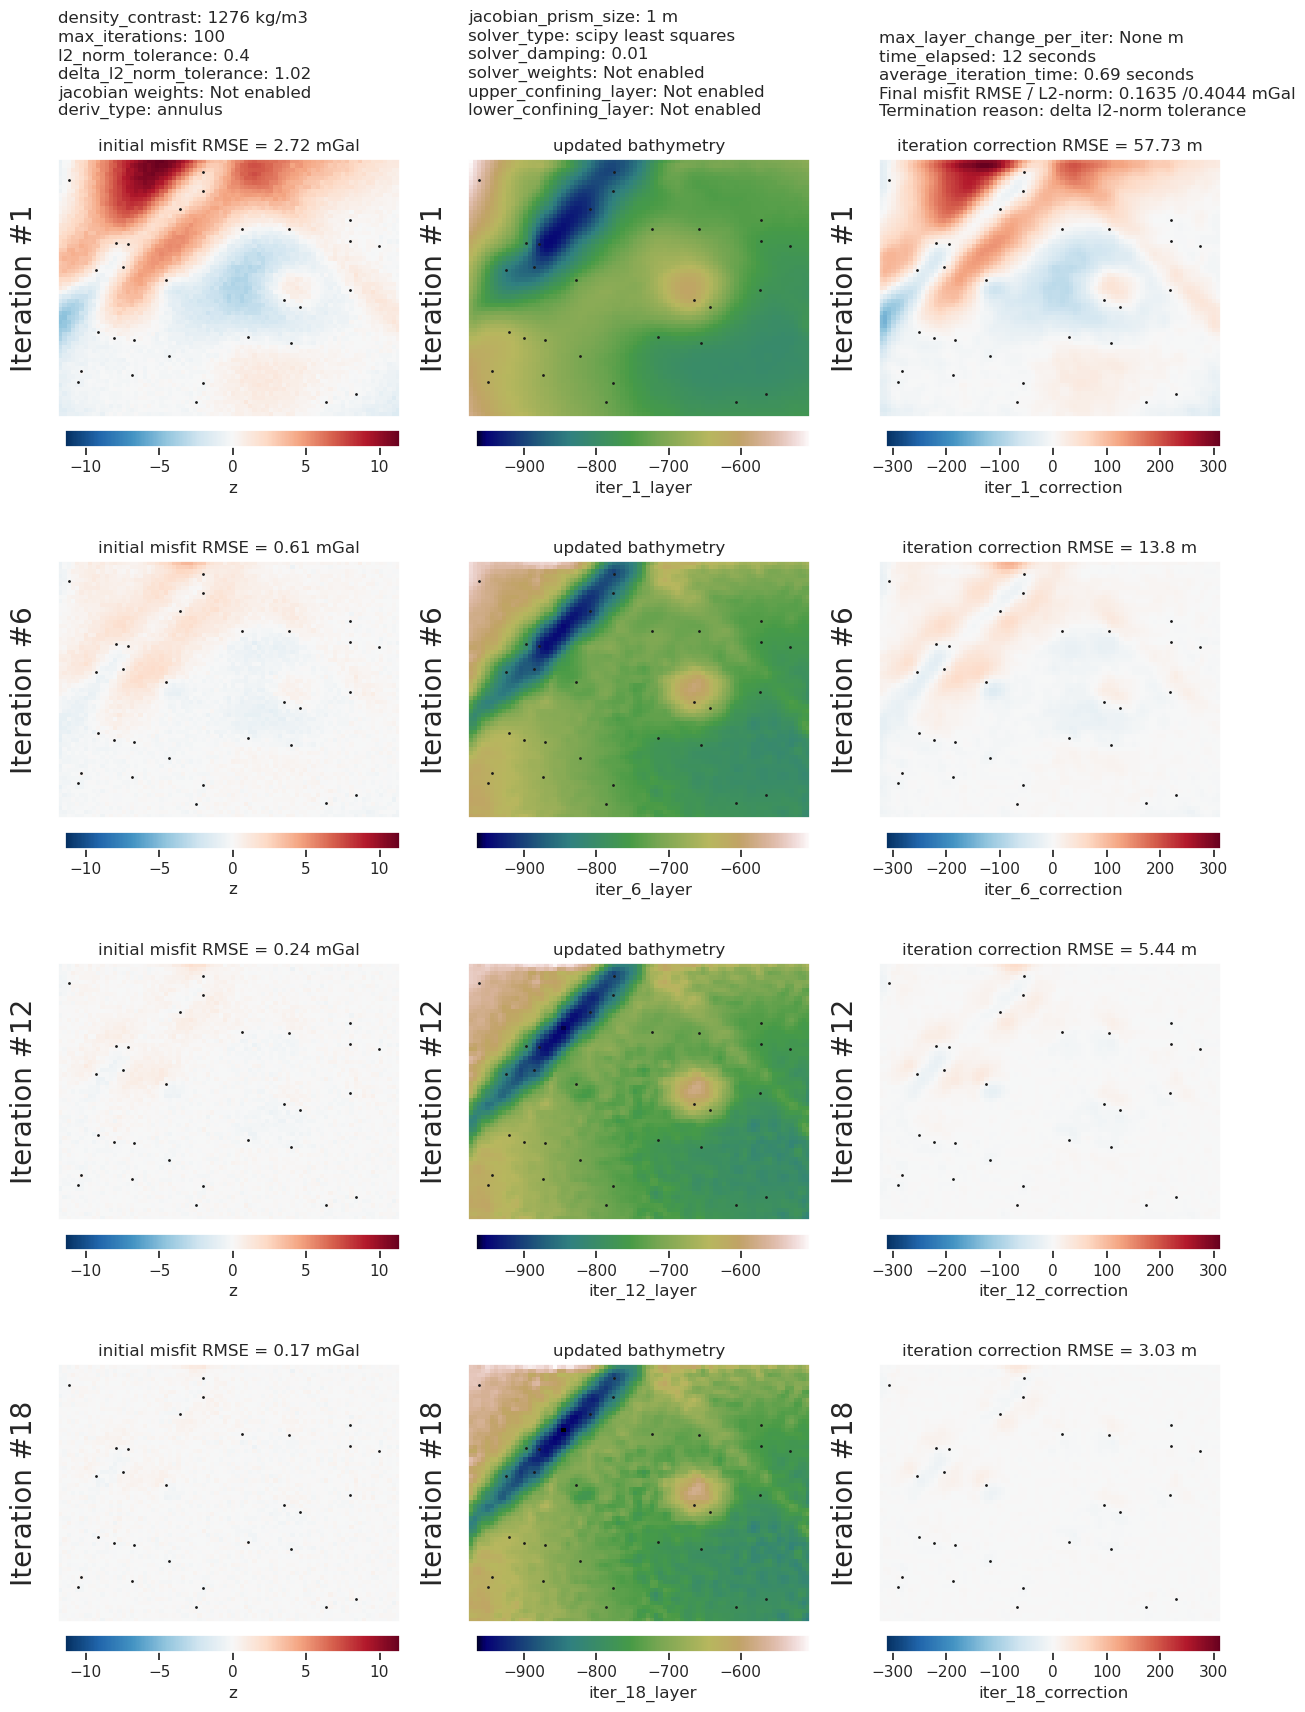

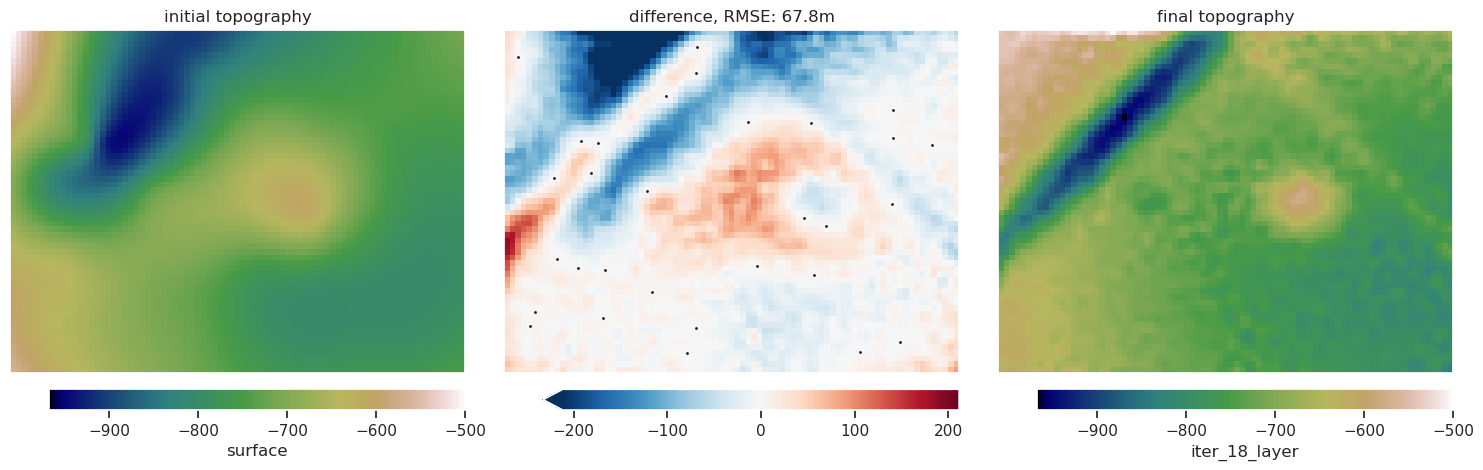

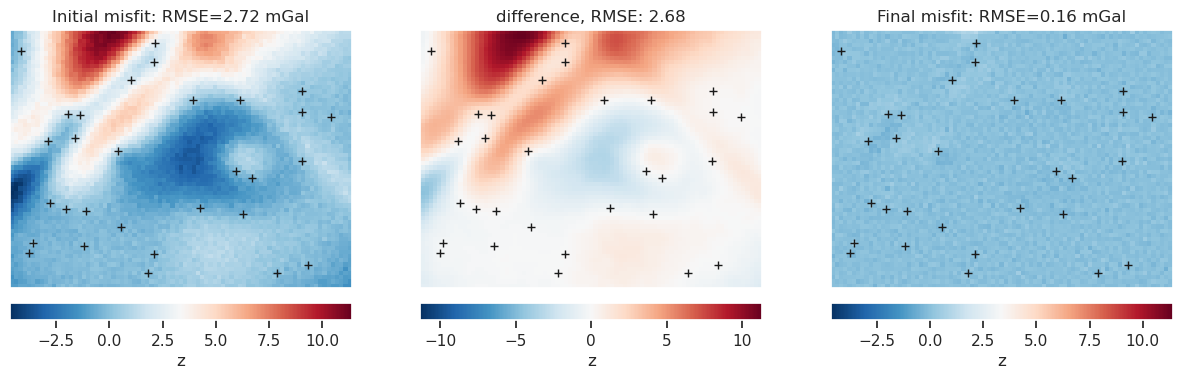

In [48]:
# with inv_utils.HiddenPrints():
#     _ = inv.inversion_RMSE(
#         results=inv_result,
#         input_grav=full_res_grav_noise[full_res_grav_noise.test==False],
#         inversion_region=inversion_region,
#         true_surface = layer1,
#         plot=True,
#         plot_type="pygmt",
#         label_offset = "j0c/.2c",
#         **kwargs,
#     )

# plotting.plot_convergence(
#     inv_result[2],
#     iter_times=inv_result[3]["iter_times"])

# _ = plotting.plot_inversion_results(
#         inv_result[2],
#         inv_result[1],
#         inv_result[3],
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {inv_result[0]}")
# print(f"constraints RMSE: {inv_result[-1]}")

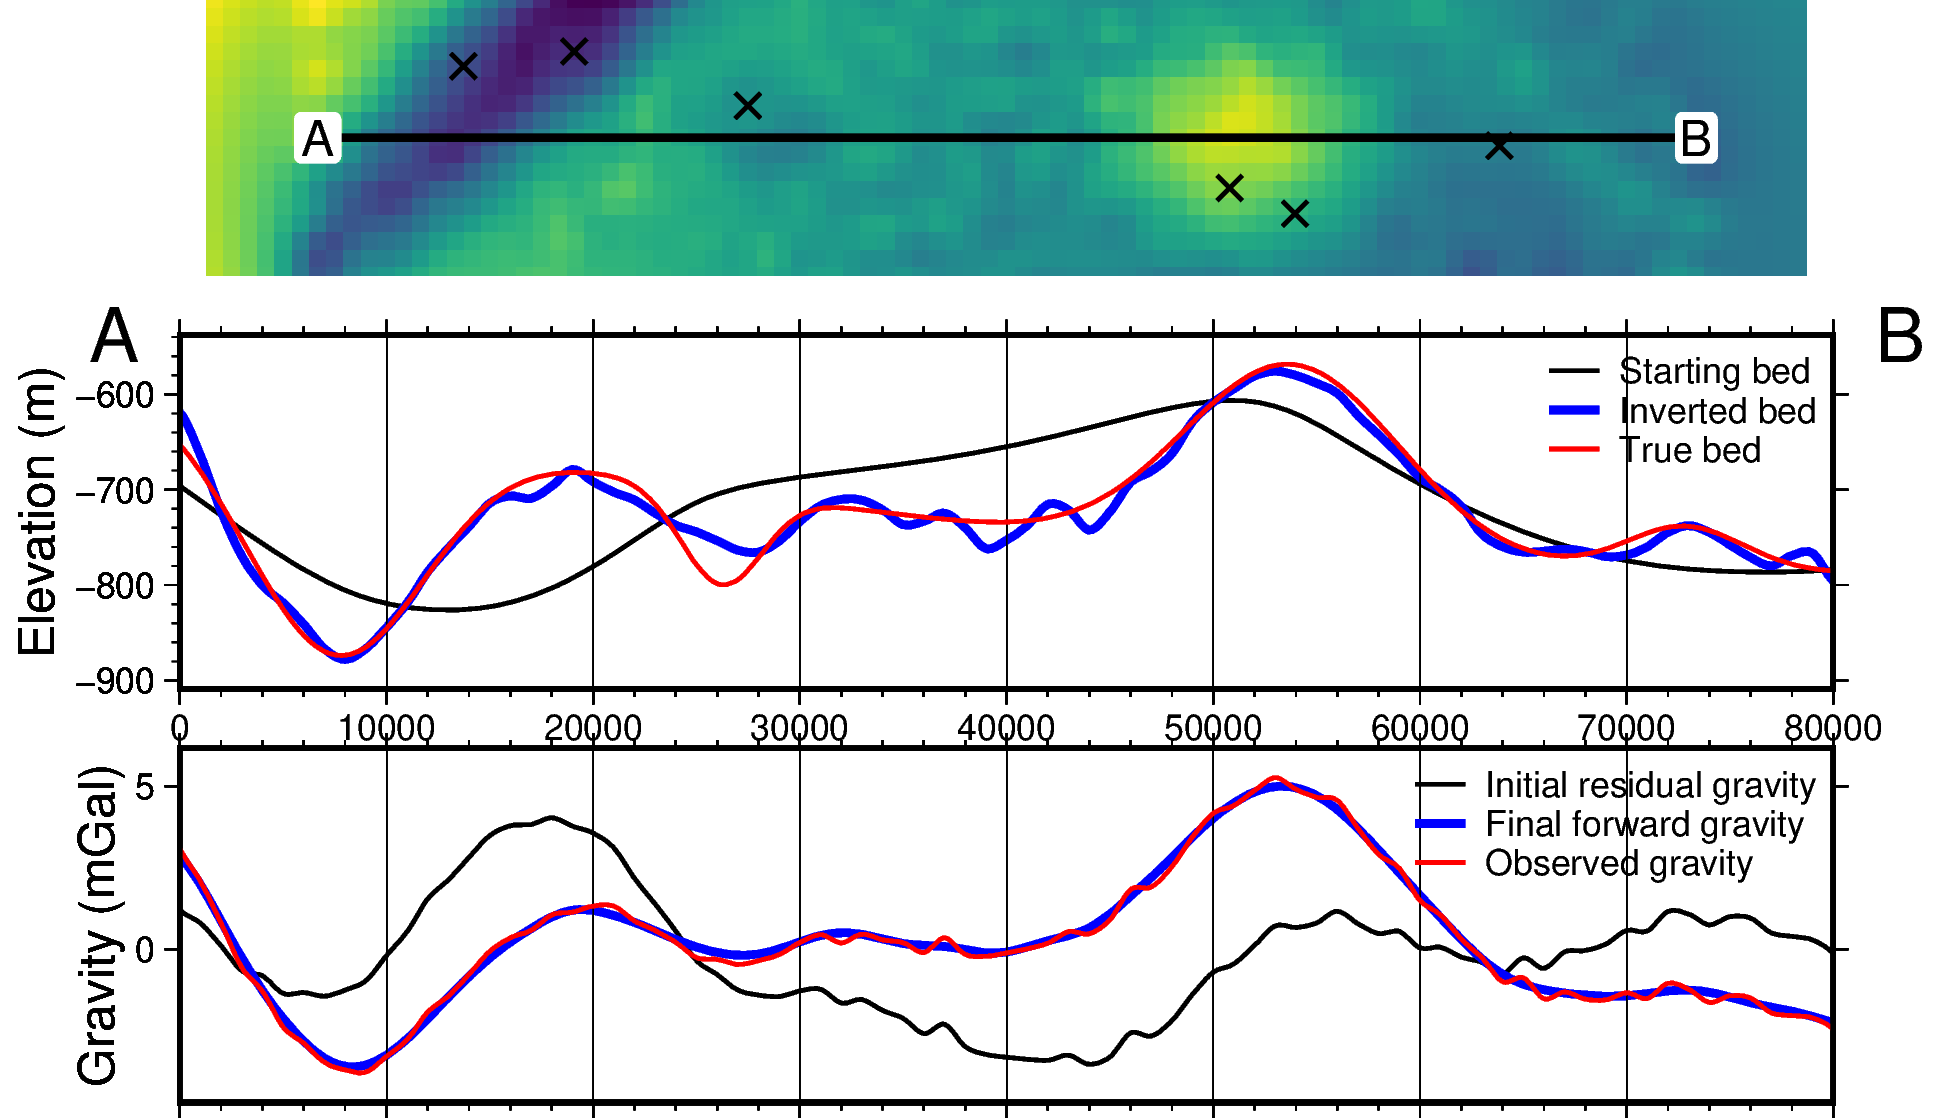

In [32]:
plotting.plot_inversion_results_profile(
    inv_result[1],
    inv_result[2],
    input_forward_column="layer1_forward",
    constraints=constraints,
    true_surface=layer1,
    start=[inversion_region[0], 30e3],
    stop=[inversion_region[1], 30e3],
    map_buffer=0.1,
    subplot_orientation="vertical",
    data_legend_loc="jTR+o0c",
    layers_legend_loc="jTR+o0c",
)

### Optimize on damping and l2 norm tolerance

In [ ]:
# # set kwargs for inversion
# inversion_kwargs = dict(
#     input_grav_column="Gobs_shift",
#     max_iterations=100,
#     delta_l2_norm_tolerance=1.01, # stop if l2-norm doesn't decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     inversion_region = inversion_region,
# )

# # set number of CV runs for each method
# n_trials = 40

# study_name = f"synthetic_simple_opti_damping_l2norm"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# # remove if exists
# for p in pathlib.Path(".").glob(f"{fname}*"):
#     pathlib.Path(p).unlink(missing_ok=True)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # create study
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="BoTorch")
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#     )
# # define the objective function
# objective_func = optimization.CV_inversion(
#     training_data = full_res_grav_noise[full_res_grav_noise.test==False],
#     testing_data = full_res_grav_noise[full_res_grav_noise.test==True],
#     fname = results_fname,
#     starting_prisms = starting_prisms,
#     true_surface = layer1,
#     l2_norm_limits = [0.01, 0.5], # l2-norm = sqrt(RMS), set to sqrt(noise)
#     l2_norm_step = .01,
#     damping_limits = [-4, -1],  # damping = 10^damping_limit
#     damping_step = .1,
#     **inversion_kwargs,
# )
# # run the optimization
# study, study_df = optimization.optuna_parallel(
#     study_name=study_name,
#     study_storage=storage,
#     objective = objective_func,
#     n_trials=n_trials,
#     maximize_cpus=True,
#     parallel=True,
# )

In [ ]:
# study_name = f"synthetic_simple_opti_damping_l2norm"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # load and plot past study
# study = optuna.load_study(
#     study_name=study_name,
#     storage=storage,
# )
# print(study.best_params)
# print(study.best_trial.number)

# # load best inversion's results
# with open(f"{results_fname}_trial_{study.best_trial.number}_results.pickle", 'rb') as f:
#     results = pickle.load(f)

# # plotting.plot_optuna_inversion_figures(
# #     study,
# #     target_names=["CV Score"],
# #     # include_duration=True,
# # #     plot_history=False,
# #     plot_edf=False,
# # )
# study_df = study.trials_dataframe().sort_values(by="value")
# study_df.head()

In [ ]:
# fig = make_subplots(rows=1, cols=3, subplot_titles=("a)","b)","c)"))

# # subplot a
# fig.add_trace(plotting.combined_importance(
#     study,
#     target_names=[""]
# ).data[0], row=1, col=1)

# # subplot b
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[0], row=1, col=2)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["damping"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 2
# )

# # subplot c
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[1], row=1, col=3)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["l2_norm_tolerance"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 3
# )

# fig['layout']['xaxis']['title']='Importance'
# fig['layout']['xaxis2']['title']='Damping'
# fig['layout']['xaxis3']['title']='L2-norm tolerance (mGal<sup>.5</sup>)'
# fig['layout']['yaxis2']['title']='Score (mGal)'
# fig['layout']['yaxis3']['title']='Score (mGal)'

# fig.update_layout(
#     showlegend=False,
#     # yaxis2_range=[-.02, .2], yaxis3_range=[-.02, .2],
#     height=400, width=1200
# )

# fig.show()
# # fig.write_image("chp3_simple_dual_opti_figs.png")

In [ ]:
# print(study.best_params)

# results = plotting.plot_best_inversion(
#     input_grav = full_res_grav_noise[full_res_grav_noise.test==False],
#     true_surface = layer1,
#     best_params = study.best_params,
#     grav_spacing = grav_spacing,
#     constraint_points = constraints,
#     plot_type = "pygmt",
#     inversion_region = inversion_region,
#     **kwargs,
# )

In [ ]:
# plotting.plot_inversion_results_profile(
#     results[1],
#     results[2],
#     input_forward_column="layer1_forward",
#     constraints = constraints,
#     true_surface = layer1,
#     start = [inversion_region[0], 30e3],
#     stop = [inversion_region[1], 30e3],
#     map_buffer = 0.1,
#     layers_legend_loc="JTR+jTR",
#     data_legend_loc="JTR+jTR",
# )

### Optimize on damping and weights grid exponent

In [ ]:
# # set kwargs for inversion
# inversion_kwargs = dict(
#     input_grav_column="Gobs_shift",
#     max_iterations=100,
#     l2_norm_tolerance=0.15, # sqrt(RMS)=l2-norm, set to sqrt(noise)
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesn't decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     inversion_region = inversion_region,
# )

# # set number of CV runs for each method
# n_trials = 40

# study_name = f"synthetic_simple_noise_CV_optimization"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# # remove if exists
# for p in pathlib.Path(".").glob(f"{fname}*"):
#     pathlib.Path(p).unlink(missing_ok=True)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # create study
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="BoTorch")
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#     )
# # define the objective function
# objective_func = optimization.CV_inversion(
#     training_data = full_res_grav_noise[full_res_grav_noise.test==False],
#     testing_data = full_res_grav_noise[full_res_grav_noise.test==True],
#     fname = results_fname,
#     starting_prisms = starting_prisms,
#     true_surface = layer1,
#     damping_limits = [-4, -1],  # damping = 10^damping_limit
#     damping_step = .1,
#     weights_exponent_limits = [.1, 1],
#     weights_exponent_step = .01,
#     layer_spacing = layer_spacing,
#     constraints = constraints,
#     **inversion_kwargs,
# )
# # run the optimization
# study, study_df = optimization.optuna_parallel(
#     study_name=study_name,
#     study_storage=storage,
#     objective = objective_func,
#     n_trials=n_trials,
#     maximize_cpus=True,
#     parallel=True,
# )

In [ ]:
# study_name = f"synthetic_simple_noise_CV_optimization"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # load and plot past study
# study = optuna.load_study(
#     study_name=study_name,
#     storage=storage,
# )
# print(study.best_params)
# print(study.best_trial.number)

# # load best inversion's results
# with open(f"{results_fname}_trial_{study.best_trial.number}_results.pickle", 'rb') as f:
#     results = pickle.load(f)

# # plotting.plot_optuna_inversion_figures(
# #     study,
# #     target_names=["CV Score"],
# #     include_duration=True,
# # #     plot_history=False,
# #     plot_edf=False,
# # )
# study_df = study.trials_dataframe().sort_values(by="value")
# study_df.head()

In [ ]:
# fig = make_subplots(rows=1, cols=3, subplot_titles=("a)","b)","c)"))

# # subplot a
# fig.add_trace(plotting.combined_importance(
#     study,
#     target_names=[""]
# ).data[0], row=1, col=1)

# # subplot b
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[0], row=1, col=2)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["damping"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 2
# )

# # subplot c
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[1], row=1, col=3)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["weights_exponent"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 3
# )

# fig['layout']['xaxis']['title']='Importance'
# fig['layout']['xaxis2']['title']='Damping'
# fig['layout']['xaxis3']['title']='Weights grid exponent'
# fig['layout']['yaxis2']['title']='Score (mGal)'
# fig['layout']['yaxis3']['title']='Score (mGal)'

# y_range = [0, .6]
# fig.update_layout(
#     showlegend=False,
#     yaxis2_range=y_range, yaxis3_range=y_range,
#     height=400, width=1200
# )

# fig.show()
# fig.write_image("chp3_simple_noise_optimization.png")

In [ ]:
# print(study.best_params)

# _ = inv.inversion_RMSE(
#     results = results,
#     true_surface = layer1,
#     inversion_region = inversion_region,
#     constraints = constraints,
#     plot=True,
#     # plot_type = "xarray",
#     points_style="+.2c",
#     # robust=True,#False,
# )

In [ ]:
# _ = plotting.plot_inversion_results(
#         results["grav_results"],
#         results["prism_results"],
#         results["params"],
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {results['rmse']}")
# print(f"constraints RMSE: {results['constraints_rmse']}")

In [ ]:
# plotting.plot_inversion_results_profile(
#     results[1],
#     results[2],
#     input_forward_column="layer1_forward",
#     constraints = constraints,
#     true_surface = layer1,
#     start = [inversion_region[0], 30e3],
#     stop = [inversion_region[1], 30e3],
#     map_buffer = 0.1,
#     layers_legend_loc="JTR+jTR",
#     data_legend_loc="JTR+jTR",
# )

## Sampled grav, no noise

[1e-10, 3.3598182862837877e-10, 1.1288378916846883e-09, 3.792690190732254e-09, 1.274274985703132e-08, 4.281332398719396e-08, 1.438449888287663e-07, 4.832930238571752e-07, 1.6237767391887209e-06, 5.455594781168514e-06, 1.8329807108324338e-05, 6.158482110660255e-05, 0.00020691380811147902, 0.0006951927961775605, 0.002335721469090121, 0.007847599703514606, 0.026366508987303555, 0.08858667904100832, 0.2976351441631313, 1.0]
[ 5000.          5789.47368421  6578.94736842  7368.42105263
  8157.89473684  8947.36842105  9736.84210526 10526.31578947
 11315.78947368 12105.26315789 12894.73684211 13684.21052632
 14473.68421053 15263.15789474 16052.63157895 16842.10526316
 17631.57894737 18421.05263158 19210.52631579 20000.        ]


Parameters:   0%|          | 0/400 [00:00<?, ?it/s]

Best score: 0.9263471755545707
Best parameters: {'damping': 0.0006951927961775605, 'depth': 11315.78947368421}
14540
4941
DC shifted observed gravity by -0.99mGal to match forward gravity.


northing  easting   test      Gobs  upward  layer1_forward  Gobs_shift  \
0           0.0      0.0  False  4.890486  1000.0        7.336436    5.882001   
1           0.0    500.0   True  4.852125  1000.0        7.196777    5.843640   
2           0.0   1000.0  False  4.803396  1000.0        7.053205    5.794911   
3           0.0   1500.0   True  4.744991  1000.0        6.907357    5.736506   
4           0.0   2000.0  False  4.677790  1000.0        6.760484    5.669305   
...         ...      ...    ...       ...     ...             ...         ...   
19476   60000.0  78000.0  False  0.798884  1000.0        0.539365    1.790399   
19477   60000.0  78500.0   True  0.779639  1000.0        0.610158    1.771154   
19478   60000.0  79000.0  False  0.757911  1000.0        0.680730    1.749426   
19479   60000.0  79500.0   True  0.733863  1000.0        0.750859    1.725378   
19480   60000.0  80000.0  False  0.707717  1000.0        0.820233    1.699232   

         misfit  reg       res  
0     -1.454435    0 -1.454435  
1     -1.353137    0 -1.353137  
2     -1.258293    0 -1.258293  
3     -1.170851    0 -1.170851  
4     -1.091179    0 -1.091179  
...         ...  ...       ...  
19476  1.251034    0  1.251034  
19477  1.160996    0  1.160996  
19478  1.068696    0  1.068696  
19479  0.974519    0  0.974519  
19480  0.878999    0  0.878999  

[19481 rows x 10 columns]

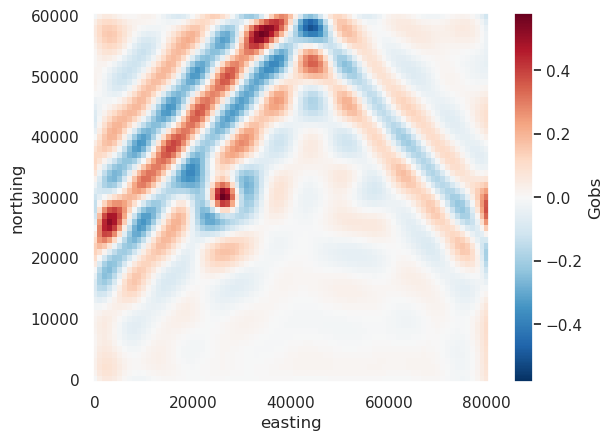

In [35]:
num = 20
dampings = list(np.logspace(-10, 0, num=num))  # -1))
# dampings.append(None)
# dampings = [None, 10**-2]
depths = np.linspace(5e3, 20e3, num)

# dampings = [10**-10, 1]
# depths = [1, 100e3]

sampled_spacing = 6e3
# sample gravity at low resolution grid, regrid at full res with eq sources
sampled_grav, score = inv_utils.resample_gravity_with_test_points(
    grav_df=full_res_grav,
    grav_column="Gobs",
    coord_columns=["easting", "northing", "upward"],
    starting_training_spacing=layer_spacing,
    coarse_training_spacing=sampled_spacing,
    region=inversion_region,
    dampings=dampings,
    depths=depths,
    optimization=False,
    # optimization = True,
    n_trials=20,
    plot=True,
)
print(len(sampled_grav[sampled_grav.test]))
print(len(sampled_grav[sampled_grav.test == False]))

# add layer1 starting forward grav into df
sampled_grav["layer1_forward"] = full_res_grav.layer1_forward

# # contaminate with noise
# sampled_grav["Gobs"] = synthetic.contaminate(
#     sampled_grav.Gobs,
#     stddev=0.04,
#     percent=True,
#     seed=0,
# )

# recalculate misfit
sampled_grav = inv.misfit(
    input_grav=sampled_grav,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraints,
)

# set regional to 0
sampled_grav["reg"] = 0
sampled_grav["res"] = sampled_grav.misfit
sampled_grav

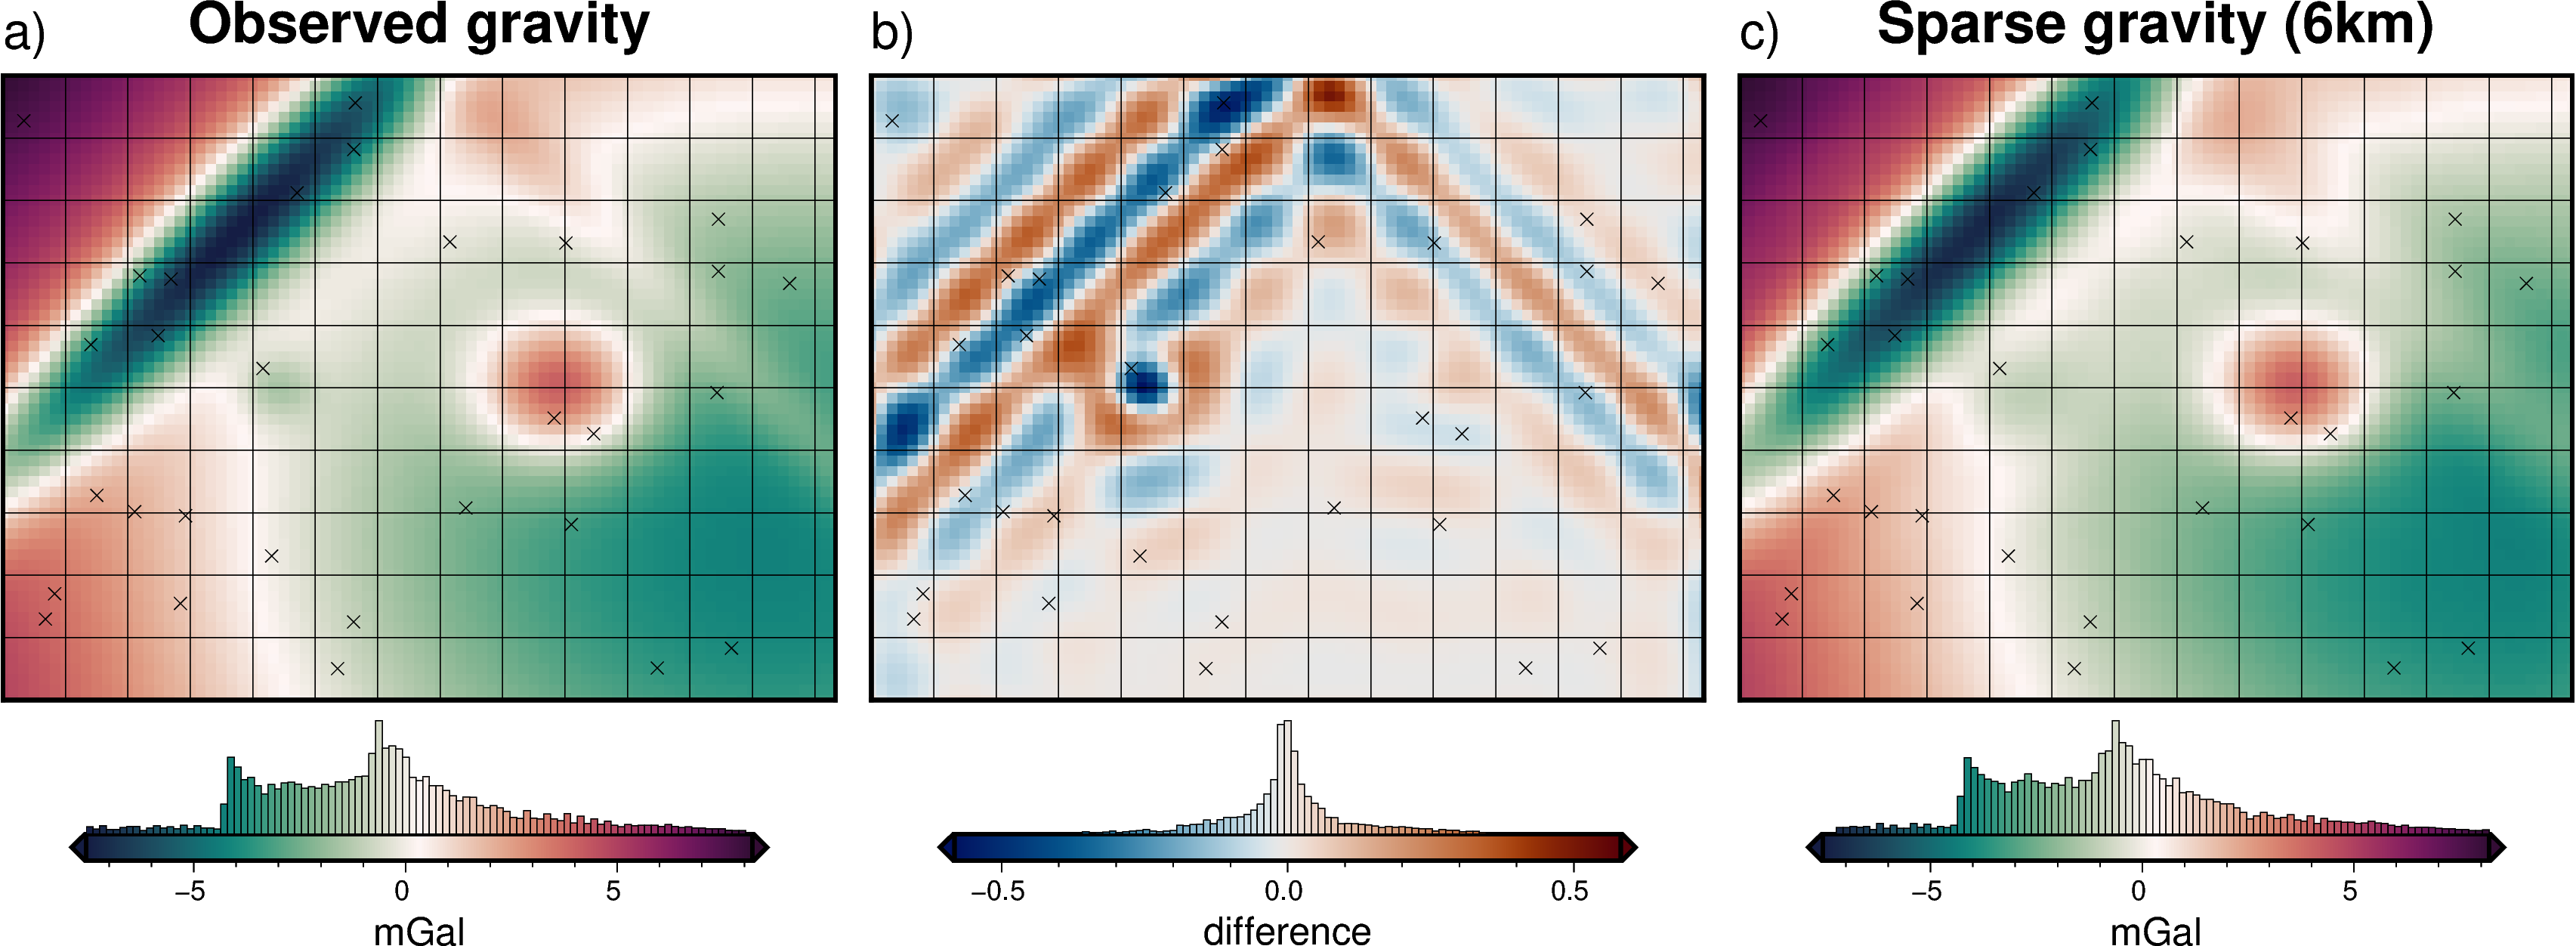

In [56]:
full_grav = (
    full_res_grav[full_res_grav.test == False]
    .set_index(["northing", "easting"])
    .to_xarray()
    .Gobs
)
sampled = (
    sampled_grav[sampled_grav.test == False]
    .set_index(["northing", "easting"])
    .to_xarray()
    .Gobs
)

_ = utils.grd_compare(
    full_grav,
    sampled,
    fig_height=7,
    grid1_name="Observed gravity",
    grid2_name=f"Sparse gravity ({int(sampled_spacing/1e3)}km)",
    title="",
    title_font="18p,Helvetica-Bold,black",
    rmse_in_title=False,  # True,
    cbar_label="mGal",
    plot=True,
    points=constraints.rename(columns={"easting": "x", "northing": "y"}),
    plot_type="pygmt",
    cmap="curl",
    diff_cmap="vik+h0",
    hist=True,
    cbar_yoffset=1.5,
    inset=False,
    points_style="x.2c",
    points_pen=None,
    subplot_labels=True,
    label_font="16p,Helvetica,black",
    robust=False,
    frame=["weSn", f"g{sampled_spacing}"],
)

In [37]:
# change spacing and resample at each new point
sampled_grav_no_eq = inv_utils.resample_with_test_points(
    sampled_spacing,  # training spacing
    full_res_grav,
    inversion_region,
)

print(len(sampled_grav_no_eq[sampled_grav_no_eq.test]))
print(len(sampled_grav_no_eq[sampled_grav_no_eq.test == False]))
sampled_grav_no_eq

434
154


northing       easting   test      Gobs  Surface2  forward_total  upward  \
0         0.0      0.000000  False  4.895946 -1.585934       3.310012  1000.0   
1         0.0   2962.962963   True  4.464934 -1.911220       2.553715  1000.0   
2         0.0   5925.925926  False  3.964539 -2.223246       1.741292  1000.0   
3         0.0   8888.888889   True  3.443497 -2.523306       0.920191  1000.0   
4         0.0  11851.851852  False  2.919775 -2.812786       0.106989  1000.0   
..        ...           ...    ...       ...       ...            ...     ...   
583   60000.0  68148.148148   True  0.952427  8.494065       9.446492  1000.0   
584   60000.0  71111.111111  False  0.886146  8.641297       9.527444  1000.0   
585   60000.0  74074.074074   True  0.844336  8.664099       9.508435  1000.0   
586   60000.0  77037.037037  False  0.824922  8.505170       9.330092  1000.0   
587   60000.0  80000.000000   True  0.820536  8.046805       8.867341  1000.0   

     layer1_forward  Gobs_shift    misfit  
0          7.336436    5.870426 -1.466010  
1          6.478156    5.439415 -1.038742  
2          5.649265    4.939018 -0.710247  
3          4.907733    4.417977 -0.489756  
4          4.244597    3.894255 -0.350342  
..              ...         ...       ...  
583       -0.853413    1.926907  2.780320  
584       -0.429629    1.860626  2.290255  
585       -0.014051    1.818816  1.832867  
586        0.402934    1.799402  1.396468  
587        0.820233    1.795015  0.974782  

[588 rows x 10 columns]

In [47]:
dampings = list(np.logspace(-10, -5, num=9))
dampings.append(None)

mindists = list(np.linspace(1, 1e3, 10))

df = sampled_grav_no_eq[sampled_grav_no_eq.test == False]

coords = (df.easting, df.northing, df.upward)

spline = inv_utils.best_SplineCV(
    coordinates=coords,
    data=df.Gobs,
    dampings=dampings,
    mindists=mindists,
    # delayed=True,
)

sampled_no_eq_grid = spline.grid(region=inversion_region, spacing=layer_spacing).scalars

Highest score: 0.9215722032484358
Best damping: None
Best mindist: 223.0


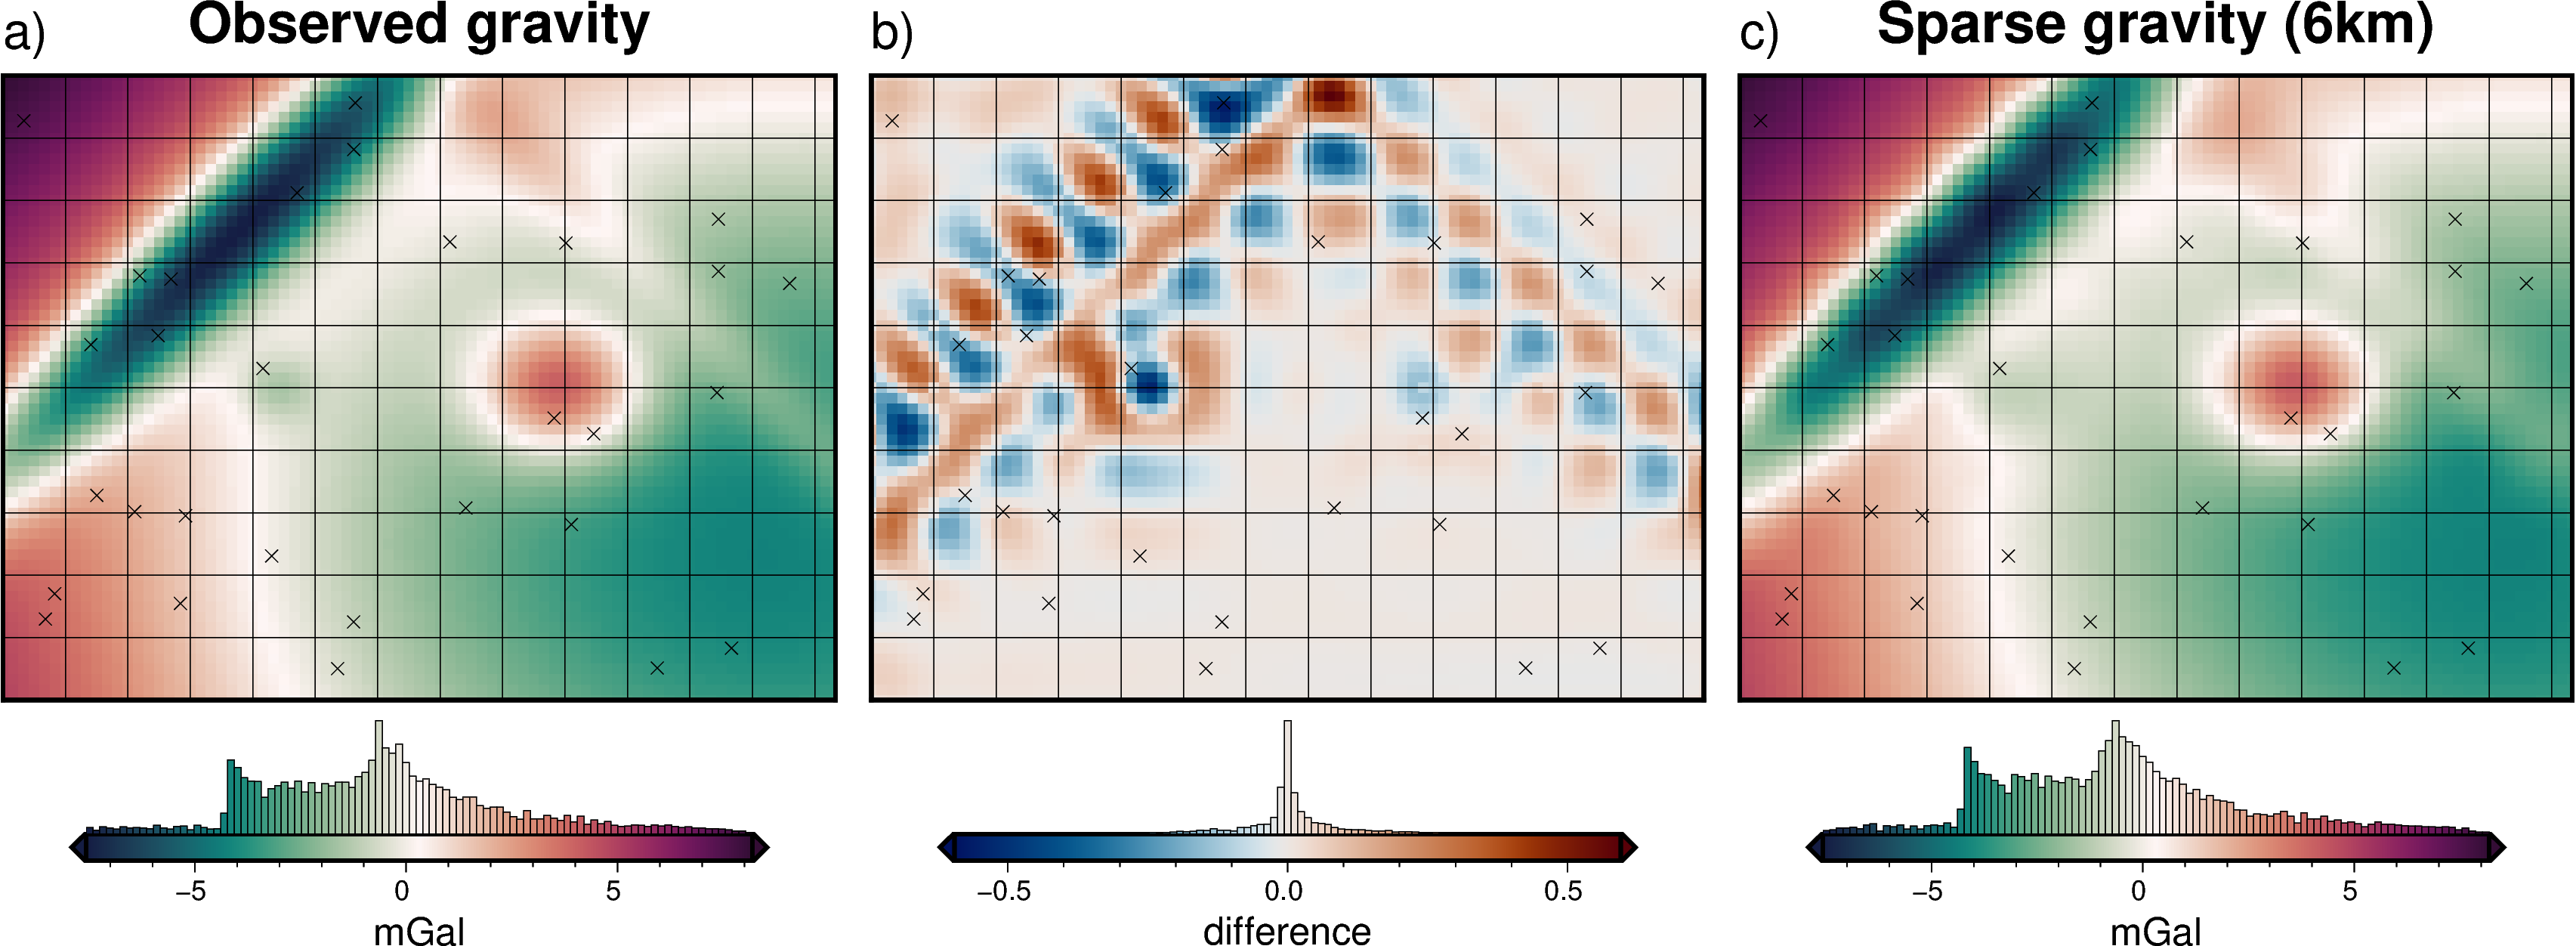

In [57]:
full_grav = (
    full_res_grav[full_res_grav.test == False]
    .set_index(["northing", "easting"])
    .to_xarray()
    .Gobs
)

_ = utils.grd_compare(
    full_grav,
    sampled_no_eq_grid,
    fig_height=7,
    grid1_name="Observed gravity",
    grid2_name=f"Sparse gravity ({int(sampled_spacing/1e3)}km)",
    title="",
    title_font="18p,Helvetica-Bold,black",
    rmse_in_title=False,  # True,
    cbar_label="mGal",
    plot=True,
    points=constraints.rename(columns={"easting": "x", "northing": "y"}),
    plot_type="pygmt",
    cmap="curl",
    diff_cmap="vik+h0",
    hist=True,
    cbar_yoffset=1.5,
    inset=False,
    points_style="x.2c",
    points_pen=None,
    subplot_labels=True,
    label_font="16p,Helvetica,black",
    robust=False,
    frame=["weSn", f"g{sampled_spacing}"],
)

In [57]:
# starting_prisms = copy.deepcopy(layer1_prisms)

# min_dist = inv_utils.normalized_mindist(
#     constraints,
#     starting_prisms,
#     mindist = layer_spacing/np.sqrt(2),
#     low = 0,
#     high = 1,
#     # region=inversion_region,
# )
# starting_prisms["weights"] = min_dist

# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=100,
#     l2_norm_tolerance=0.15,
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesnt decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 0.01,
#     plot_convergence=True,
# )

# with inv_utils.HiddenPrints():
#     results = inv.inversion_RMSE(
#         input_grav=sampled_grav[sampled_grav.test==False],
#         inversion_region=inversion_region,
#         true_surface = layer1,
#         constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#         plot=True,
#         plot_type="xarray",
#         **kwargs,
#     )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

In [ ]:
# plotting.misfit_plotting(
#     sampled_grav,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

### Optimize only for damping

Hyperparameter:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

  0%|                                                                                      | 0/14540 [00:00<?,…

Best score of 0.018496906161782907 with Hyperparameter=0.001
Best score: 0.018496906161782907
Best damping: 0.001


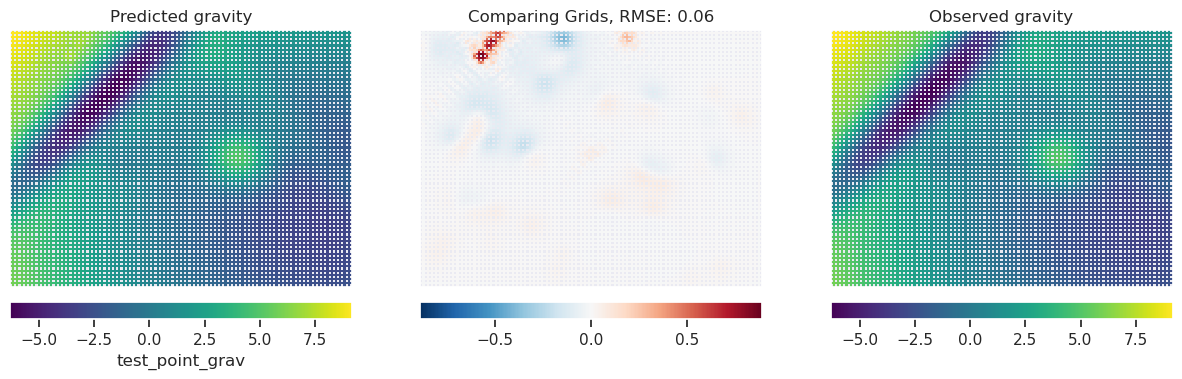

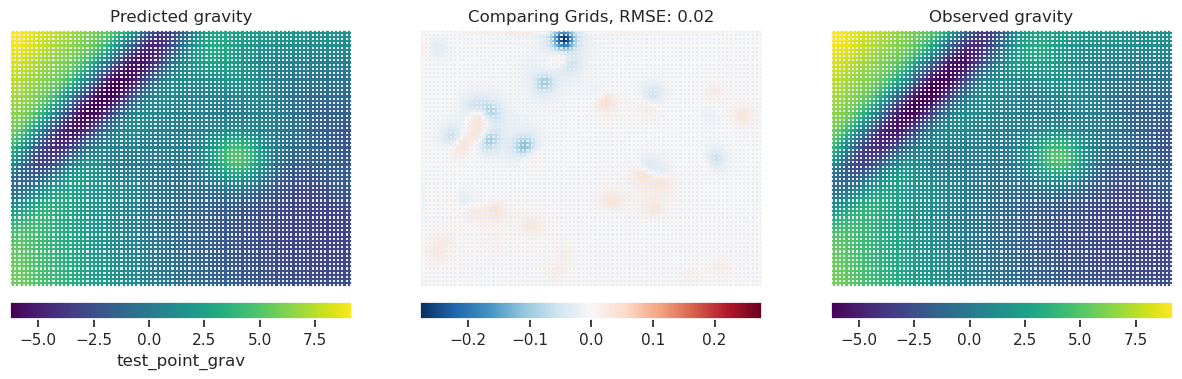

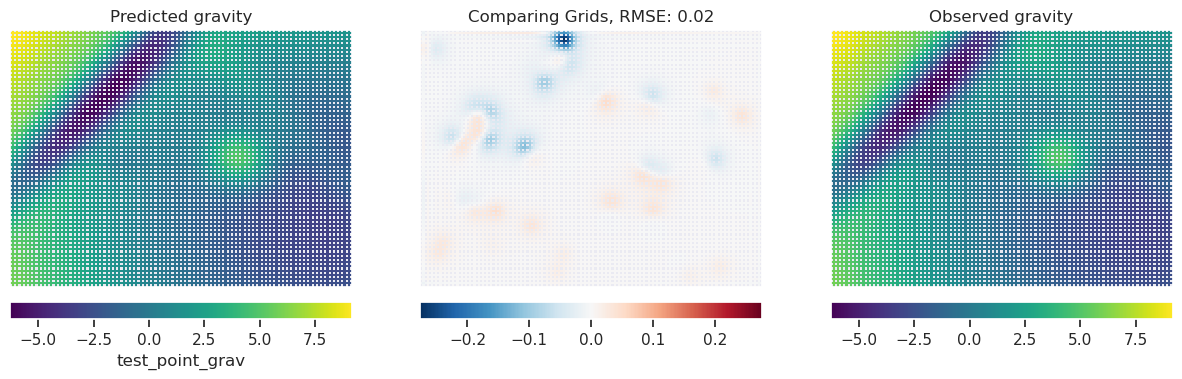

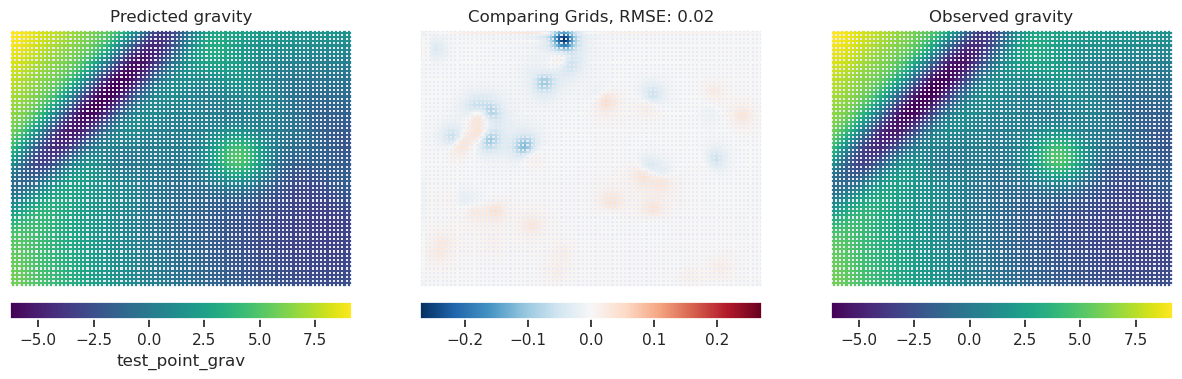

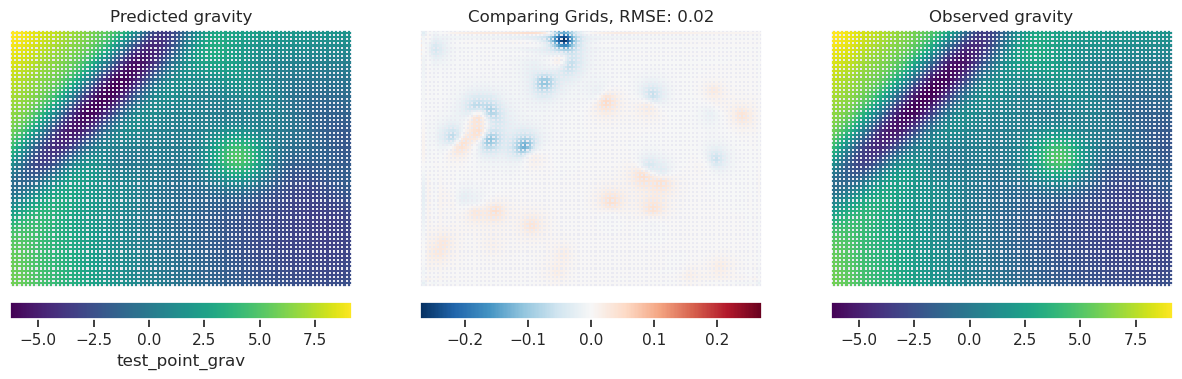

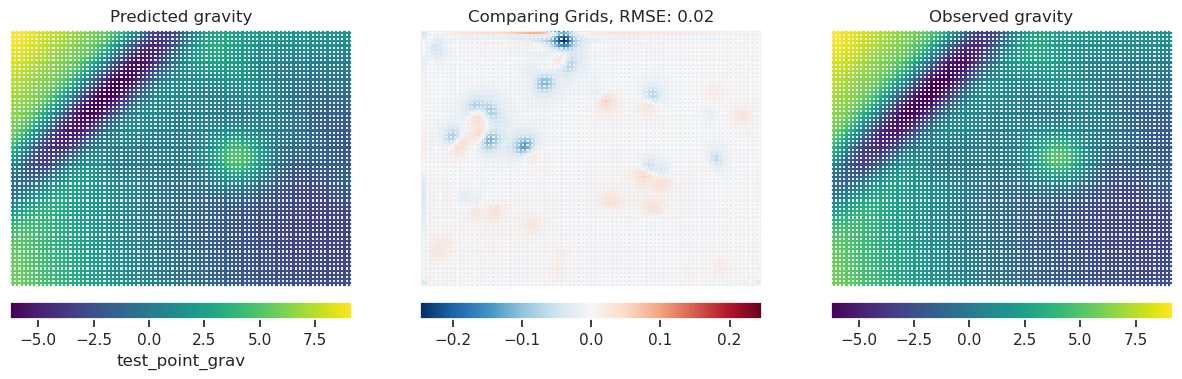

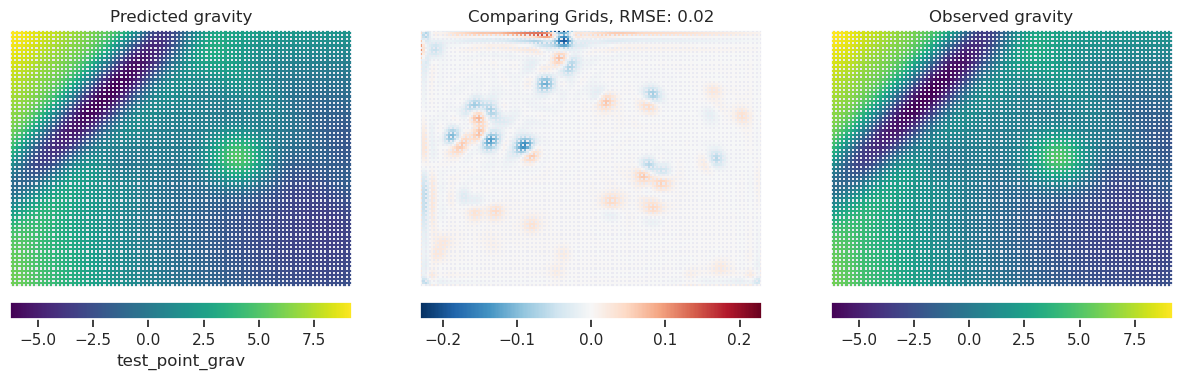

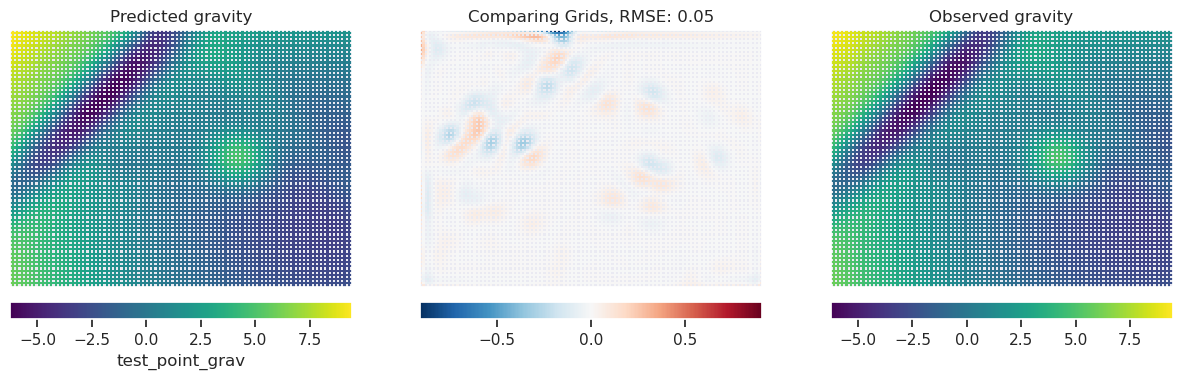

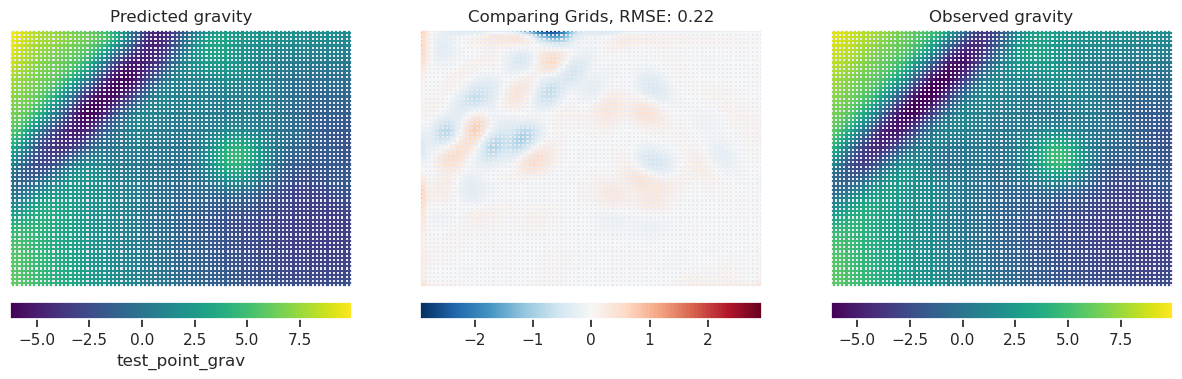

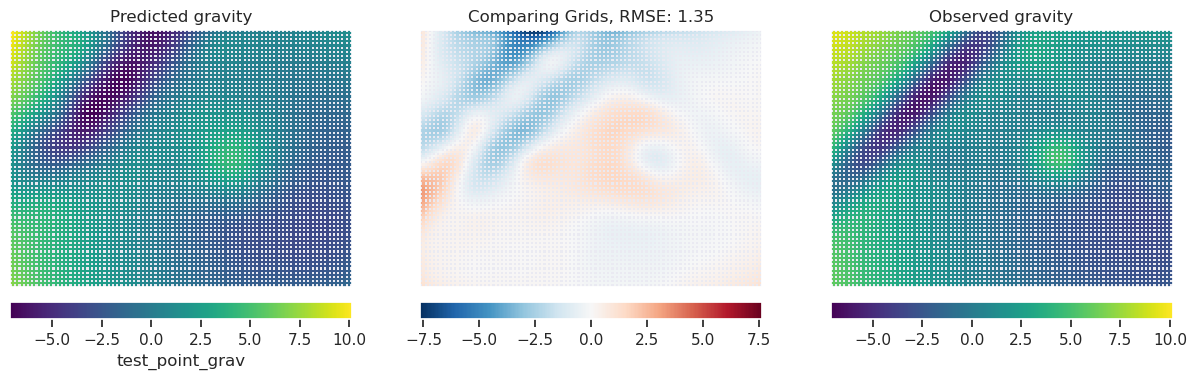

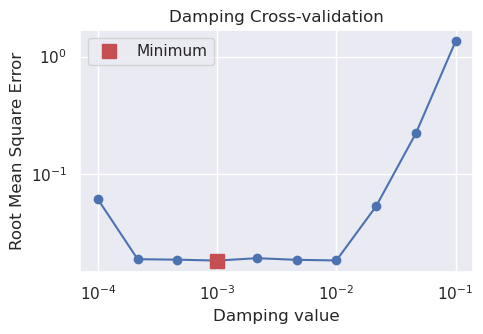

In [58]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.14,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    constraints=constraints,
)

# fname = "../synthetic_data/synthetic_simple_sampled_4k_damping_CV_no_weight_exponent.pickle"
fname = "../synthetic_data/synthetic_simple_sampled_6k_damping_CV_eq_sources.pickle"
dampings = np.logspace(-4, -1, 10)
# print(f"Damping values: {dampings}")

scores, rmses = inv.inversion_optimal_parameters(
    training_data=sampled_grav[sampled_grav.test == False],
    testing_data=sampled_grav[sampled_grav.test == True],
    parameter_values=dampings,
    function=inv.inversion_damping_MSE,
    plot=False,
    plot_grids=True,
    results_fname=fname,
    progressbar=True,
    true_surface=layer1,
    inversion_region=inversion_region,
    **kwargs,
)

# put scores and damping values into dict
CV_results = dict(scores=scores, dampings=dampings, rmses=rmses)

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)

# save scores and dampings to pickle
with open(f"{fname}.pickle", "wb") as f:
    pickle.dump(CV_results, f)

# load scores and dampings from pickle
with open(f"{fname}.pickle", "rb") as f:
    CV_results = pickle.load(f)

best = np.argmin(CV_results["scores"])
print("Best score:", CV_results["scores"][best])
print("Best damping:", CV_results["dampings"][best])

# get best inversion result of each set
with open(f"{fname}_trial_{best}.pickle", "rb") as f:
    inv_result = pickle.load(f)

plotting.plot_parameter_cv(
    CV_results["scores"],
    CV_results["dampings"],
    logx=True,
    logy=True,
    param_name="Damping",
)

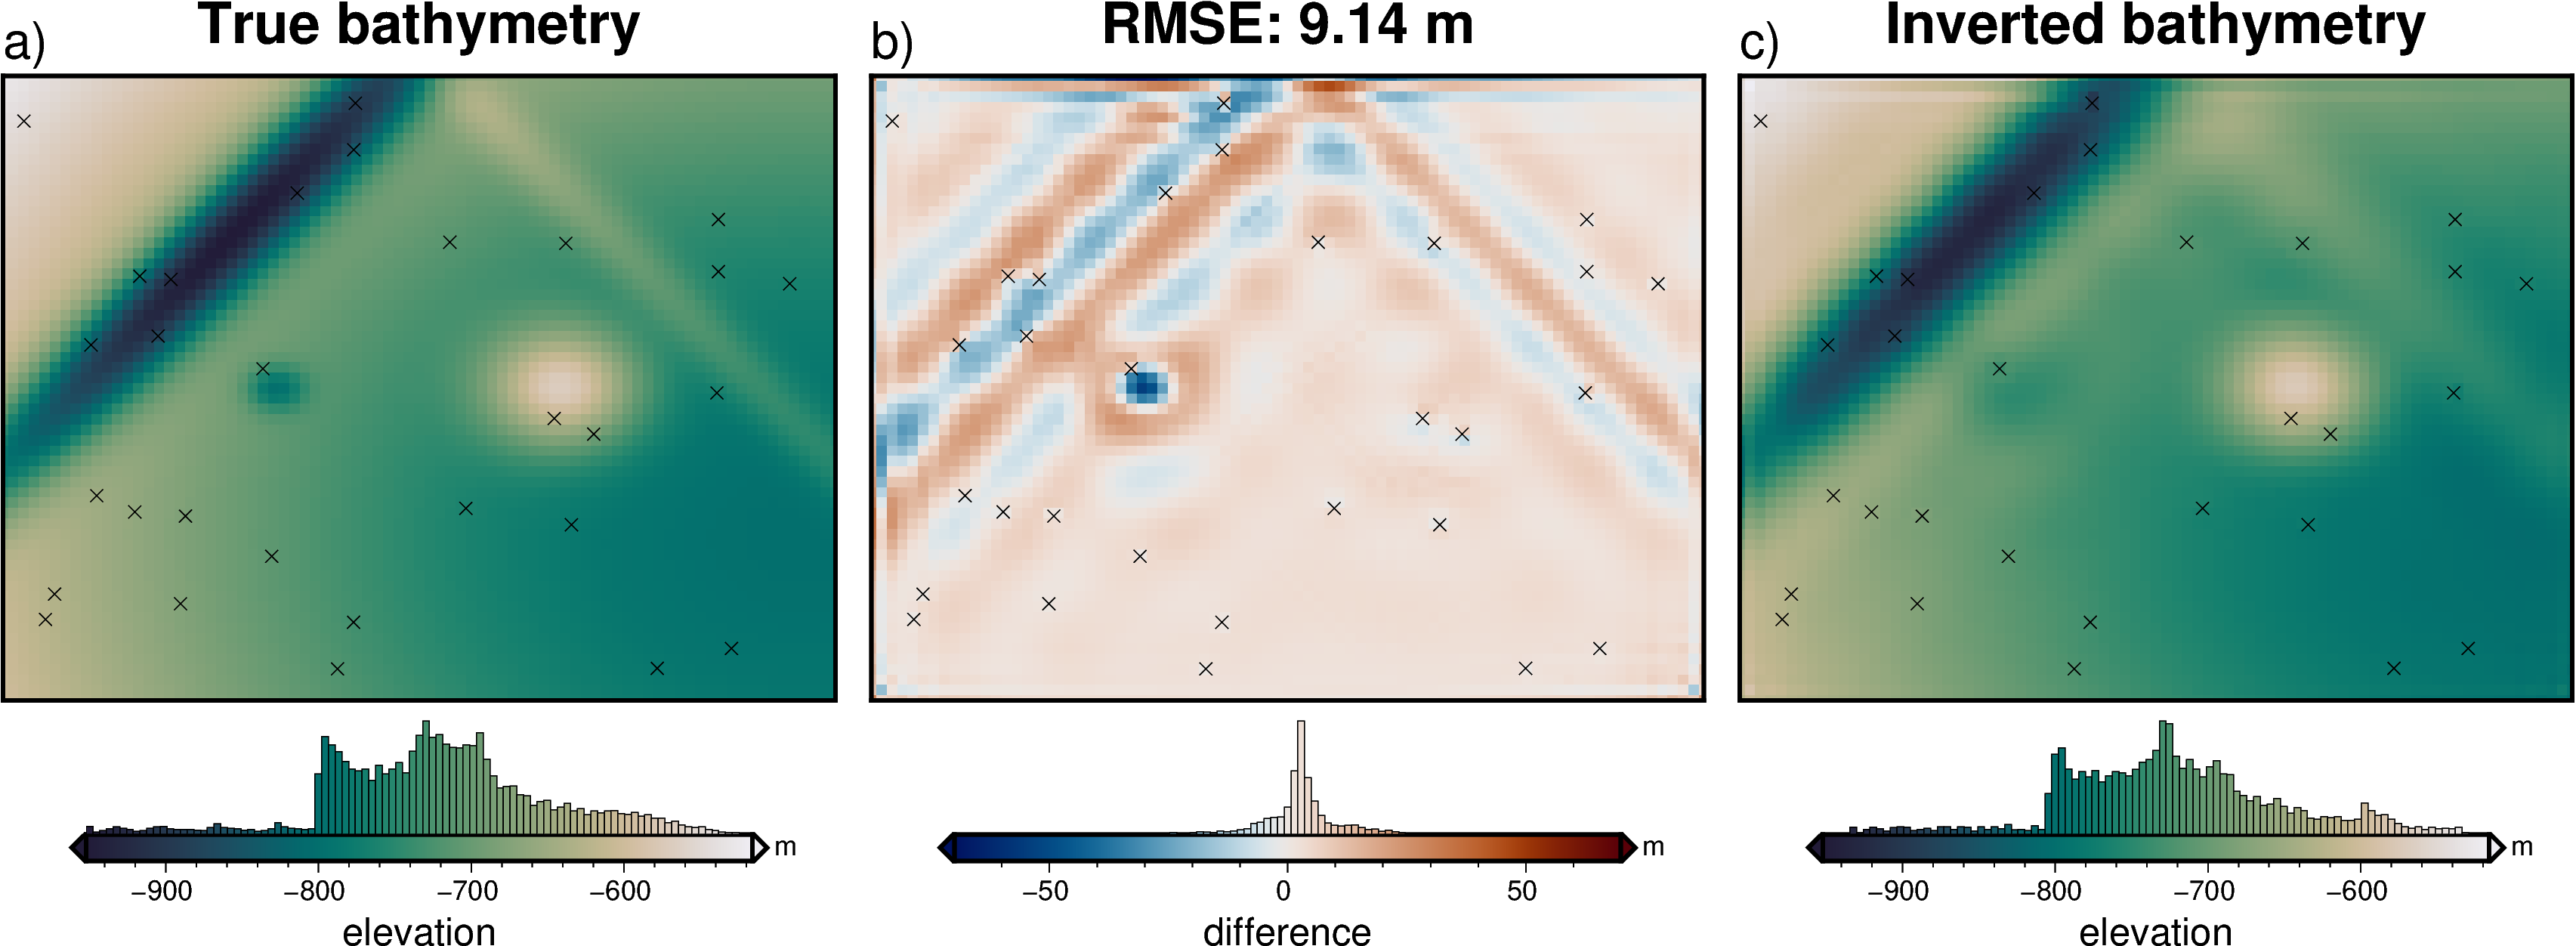

RMSE: 9.136179642311927
constraints RMSE: 1.44


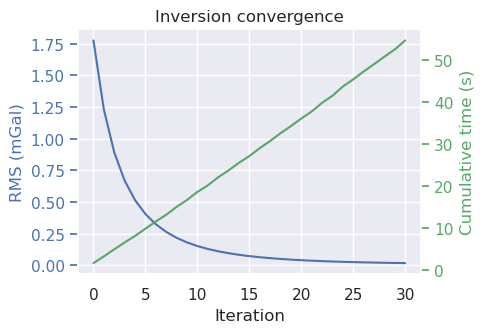

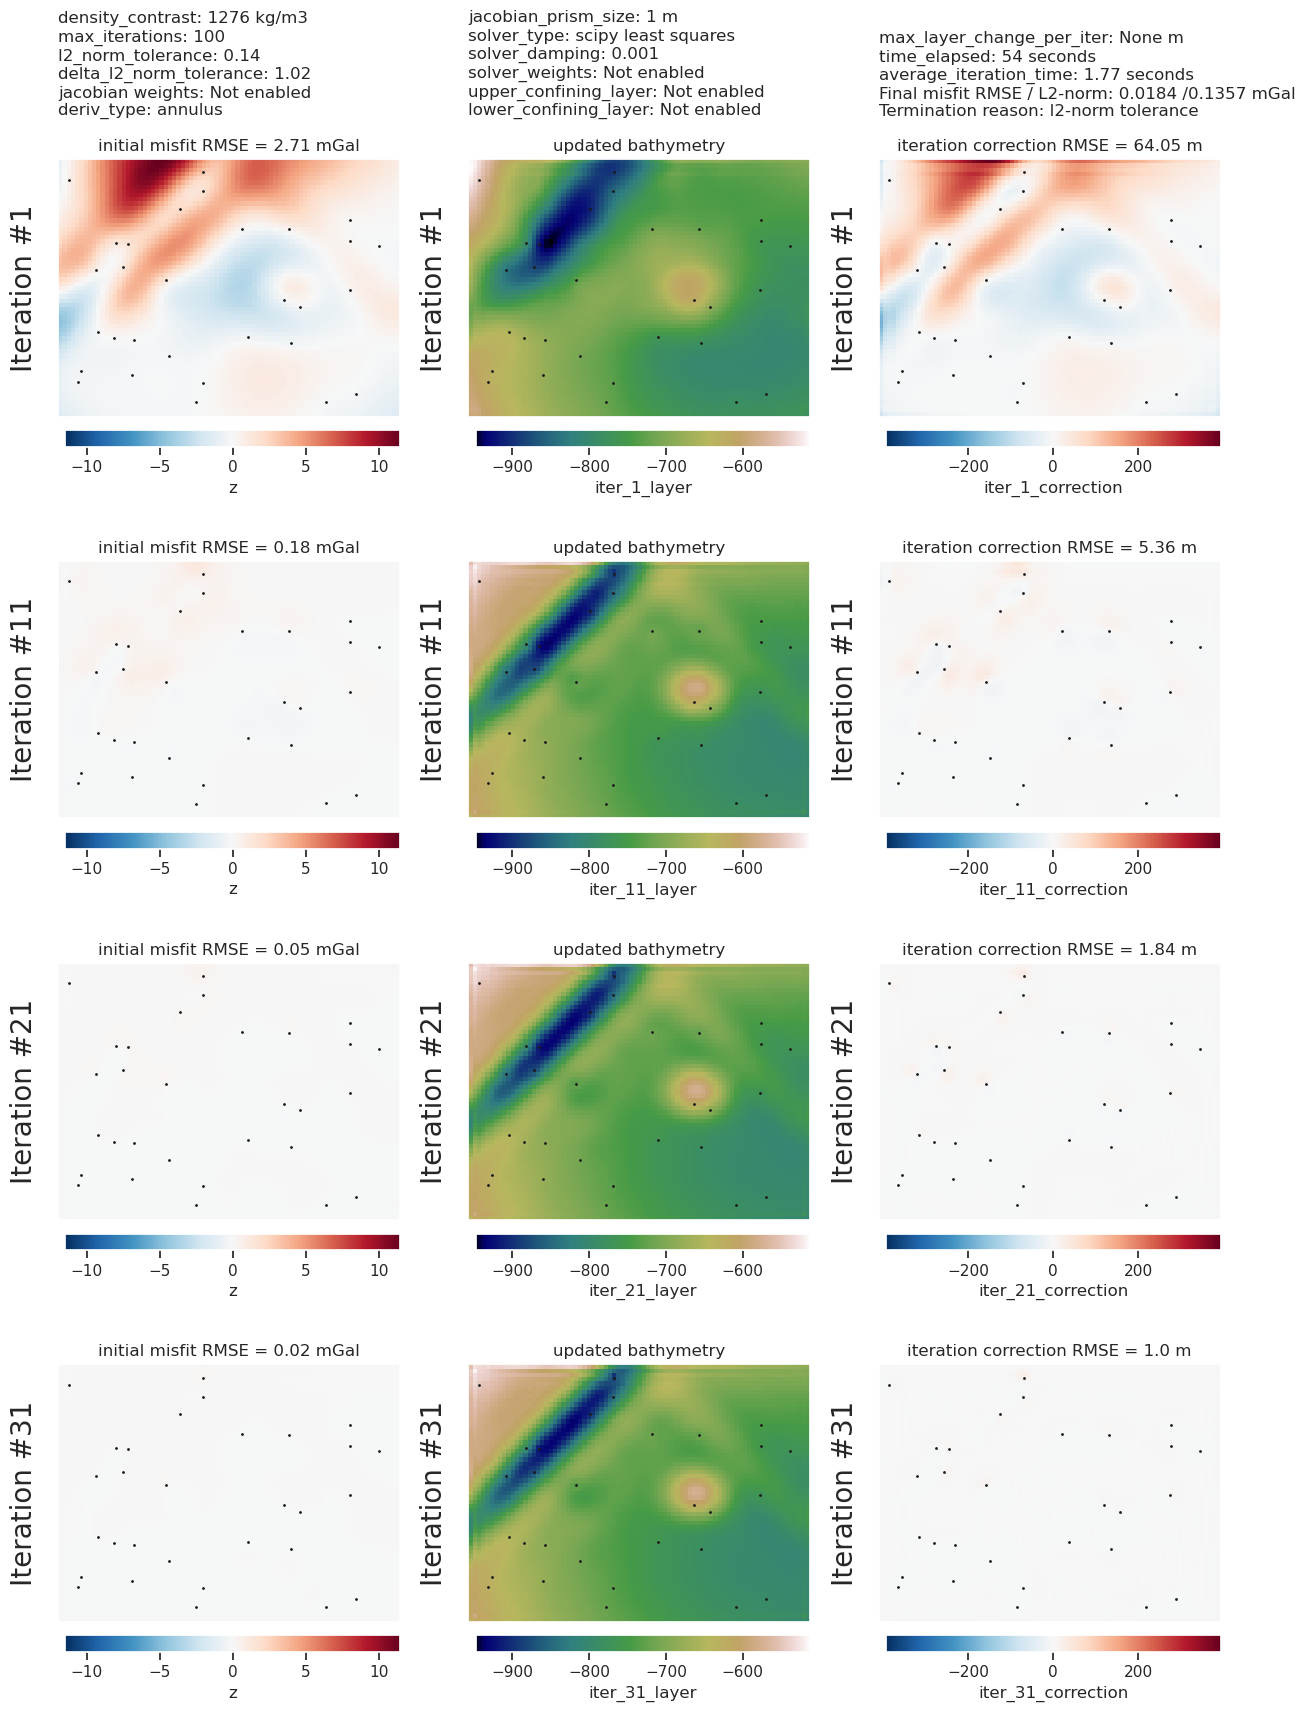

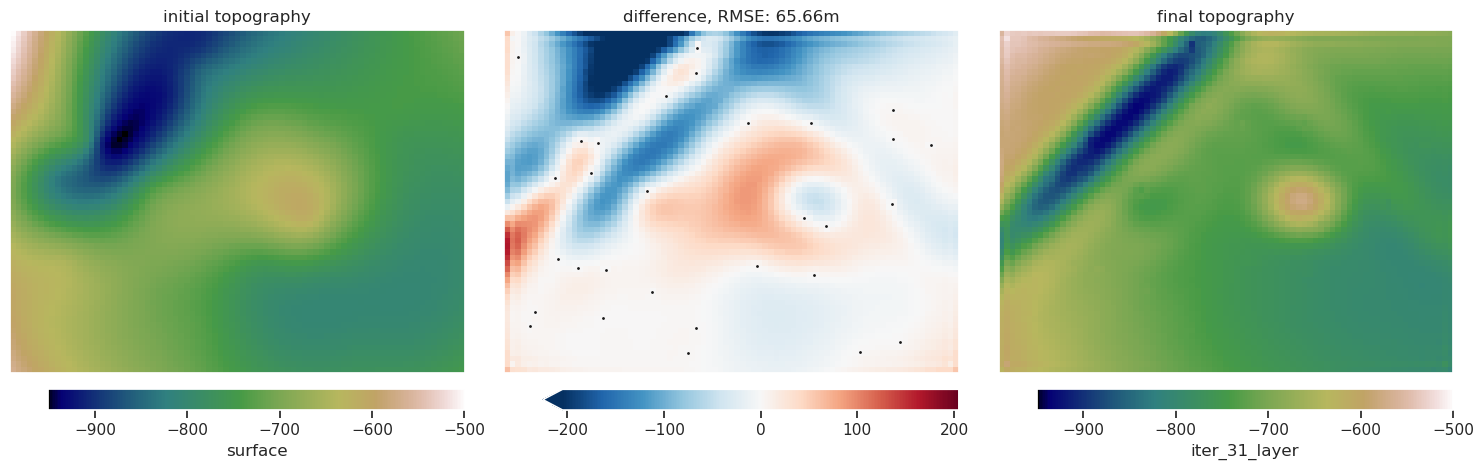

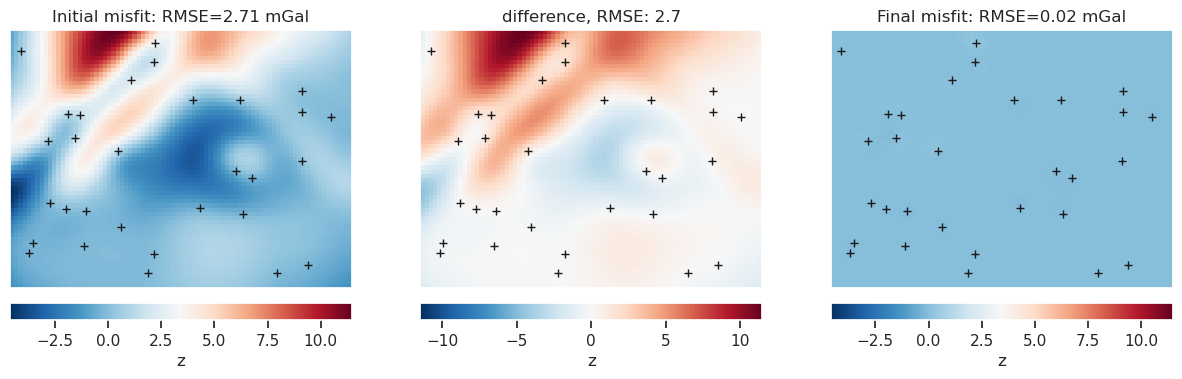

In [61]:
with inv_utils.HiddenPrints():
    _ = inv.inversion_RMSE(
        results=inv_result,
        input_grav=sampled_grav[sampled_grav.test == False],
        inversion_region=inversion_region,
        true_surface=layer1,
        plot=True,
        plot_type="pygmt",
        label_offset="j0c/.2c",
        **kwargs,
    )

plotting.plot_convergence(inv_result[2], iter_times=inv_result[3]["iter_times"])

_ = plotting.plot_inversion_results(
    inv_result[2],
    inv_result[1],
    inv_result[3],
    grav_region=inversion_region,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    iters_to_plot=4,
    grav_spacing=grav_spacing,
    constraints=constraints,
)

print(f"RMSE: {inv_result[0]}")
print(f"constraints RMSE: {inv_result[-1]}")

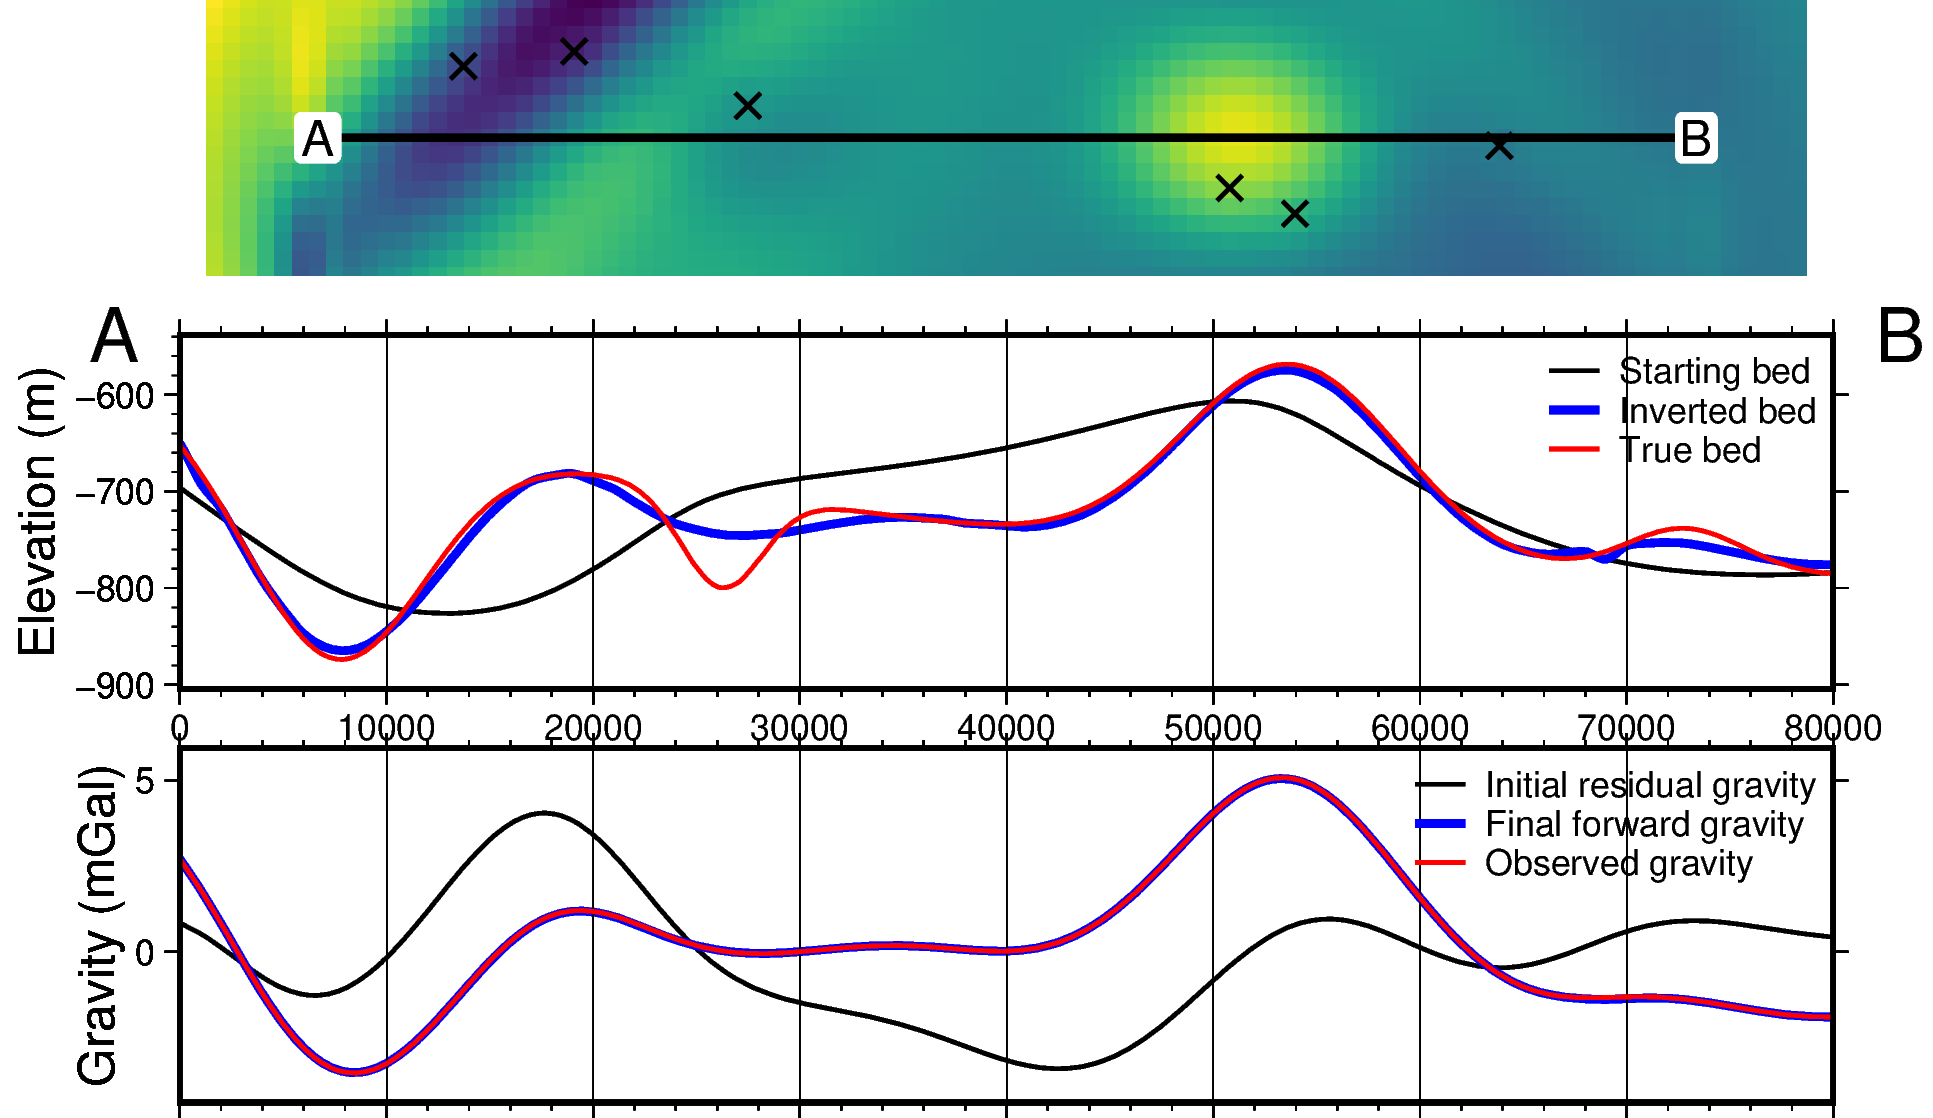

In [60]:
plotting.plot_inversion_results_profile(
    inv_result[1],
    inv_result[2],
    input_forward_column="layer1_forward",
    constraints=constraints,
    true_surface=layer1,
    start=[inversion_region[0], 30e3],
    stop=[inversion_region[1], 30e3],
    map_buffer=0.1,
    subplot_orientation="vertical",
    data_legend_loc="jTR+o0c",
    layers_legend_loc="jTR+o0c",
)

### Optimize on damping and weights grid exponent

In [ ]:
# # set kwargs for inversion
# inversion_kwargs = dict(
#     input_grav_column="Gobs_shift",
#     max_iterations=100,
#     l2_norm_tolerance=0.15, # sqrt(RMS)=l2-norm, set to sqrt(noise)
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesn't decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     inversion_region = inversion_region,
# )

# # set number of CV runs for each method
# n_trials = 40

# study_name = f"synthetic_simple_sampled_CV_optimization"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# # remove if exists
# for p in pathlib.Path(".").glob(f"{fname}*"):
#     pathlib.Path(p).unlink(missing_ok=True)

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # create study
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="BoTorch")
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#     )
# # define the objective function
# objective_func = optimization.CV_inversion(
#     training_data = sampled_grav[sampled_grav.test==False],
#     testing_data = sampled_grav[sampled_grav.test==True],
#     fname = results_fname,
#     starting_prisms = starting_prisms,
#     true_surface = layer1,
#     damping_limits = [-4, -1],  # damping = 10^damping_limit
#     damping_step = .1,
#     weights_exponent_limits = [.1, 1],
#     weights_exponent_step = .01,
#     layer_spacing = layer_spacing,
#     constraints = constraints,
#     **inversion_kwargs,
# )
# # run the optimization
# study, study_df = optimization.optuna_parallel(
#     study_name=study_name,
#     study_storage=storage,
#     objective = objective_func,
#     n_trials=n_trials,
#     maximize_cpus=True,
#     parallel=True,
# )

In [ ]:
# study_name = f"synthetic_simple_sampled_CV_optimization"
# fname = f"../optimization_logs/{study_name}.log"
# results_fname = f"../synthetic_data/{study_name}"

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#     storage = JournalStorage(JournalFileStorage(fname))

# # load and plot past study
# study = optuna.load_study(
#     study_name=study_name,
#     storage=storage,
# )
# print(study.best_params)
# print(study.best_trial.number)

# # load best inversion's results
# with open(f"{results_fname}_trial_{study.best_trial.number}_results.pickle", 'rb') as f:
#     results = pickle.load(f)

# # plotting.plot_optuna_inversion_figures(
# #     study,
# #     target_names=["CV Score"],
# #     include_duration=True,
# # #     plot_history=False,
# #     plot_edf=False,
# # )
# study_df = study.trials_dataframe().sort_values(by="value")
# study_df.head()

In [ ]:
# fig = make_subplots(rows=1, cols=3, subplot_titles=("a)","b)","c)"))

# # subplot a
# fig.add_trace(plotting.combined_importance(
#     study,
#     target_names=[""]
# ).data[0], row=1, col=1)

# # subplot b
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[0], row=1, col=2)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["damping"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 2
# )

# # subplot c
# fig.add_trace(optuna.visualization.plot_slice(
#     study, target_name="",
# ).data[1], row=1, col=3)
# # add minimum value
# fig.add_traces(
#     go.Scatter(mode="markers",
#         x=[study.best_trial.params["weights_exponent"]],
#         y=[study.best_trial.value],
#         marker=dict(color="orangered", size=10, symbol="x",
#             line=dict(width=1, color="DarkSlateGrey"))),
#     1, 3
# )

# fig['layout']['xaxis']['title']='Importance'
# fig['layout']['xaxis2']['title']='Damping'
# fig['layout']['xaxis3']['title']='Weights grid exponent'
# fig['layout']['yaxis2']['title']='Score (mGal)'
# fig['layout']['yaxis3']['title']='Score (mGal)'

# y_range = [0, .6]
# fig.update_layout(
#     showlegend=False,
#     # yaxis2_range=y_range, yaxis3_range=y_range,
#     height=400, width=1200
# )

# fig.show()
# fig.write_image("chp3_simple_sampled_optimization.png")

In [ ]:
# print(study.best_params)

# _ = inv.inversion_RMSE(
#     results = results,
#     true_surface = layer1,
#     inversion_region = inversion_region,
#     constraints = constraints,
#     plot=True,
#     # plot_type = "xarray",
#     points_style="+.2c",
#     # robust=True,#False,
# )

In [ ]:
# _ = plotting.plot_inversion_results(
#         results["grav_results"],
#         results["prism_results"],
#         results["params"],
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {results['rmse']}")
# print(f"constraints RMSE: {results['constraints_rmse']}")

In [ ]:
# plotting.plot_inversion_results_profile(
#     results[1],
#     results[2],
#     input_forward_column="layer1_forward",
#     constraints = constraints,
#     true_surface = layer1,
#     start = [inversion_region[0], 30e3],
#     stop = [inversion_region[1], 30e3],
#     map_buffer = 0.1,
#     layers_legend_loc="JTR+jTR",
#     data_legend_loc="JTR+jTR",
# )

# Optimize on damping for ensemble of noise levels and cell sizes

## create set of grav dataframe with various levels of noise and grid spacings

In [1]:
# # noise_levels = [0, .09] # decimal percent gaussian noise
# # cell_sizes = [2e3, 10e3] # cell size to resample gravity data at
# noise_levels = [0, .01, .02, .03, .04, .05, .06, .07, .08, .09] # decimal percent gaussian noise
# cell_sizes = [1e3, 2e3, 3e3, 4e3, 5e3, 6e3, 7e3, 8e3, 9e3, 10e3,] # cell size to resample gravity data at

# param_coords = []
# eq_scores = []
# grav_dfs = []
# for (n,c) in product(noise_levels, cell_sizes, desc="Noise/Cell Size"):
#     param_coords.append([n,c])

#     # sample gravity at low resolution grid, regrid at full res with eq sources
#     if c == layer_spacing:
#         sampled_grav = full_res_grav.copy()
#         eq_score = 1
#     else:
#         # parameter values, if using grid search
#         # num = 20
#         # dampings = list(np.logspace(-6, 2, num=num-1))
#         # dampings.append(None)
#         # depths = np.linspace(1, 50e3, num)

#         #parameter ranges, if using optimization
#         dampings = [10**-5, 2]
#         depths = [1, 50e3]

#         sampled_grav, eq_score = inv_utils.resample_gravity_with_test_points(
#             grav_df = full_res_grav,
#             grav_column = "Gobs",
#             coord_columns = ["easting", "northing", "upward"],
#             starting_training_spacing = layer_spacing,
#             coarse_training_spacing = c,
#             region = inversion_region,
#             dampings = dampings,
#             depths = depths,
#             optimization = True,
#             # optimization = False,
#             n_trials = 100,
#             plot=False,
#             log_fname = "../tmp_outputs/tmp",
#         )
#         # add layer1 starting forward grav into df
#         sampled_grav["layer1_forward"] = full_res_grav.layer1_forward

#     # add noise to data
#     sampled_grav["Gobs"] = synthetic.contaminate(
#         sampled_grav.Gobs,
#         stddev=n,
#         percent=True,
#         seed=0,
#     )

#     # recalculate misfit
#     sampled_grav = inv.misfit(
#         input_grav=sampled_grav,
#         input_forward_column="layer1_forward",
#         input_grav_column="Gobs",
#         constraints=constraints,
#     )

#     # set regional to 0
#     sampled_grav["reg"] = 0
#     sampled_grav["res"] =  sampled_grav.misfit

#     eq_scores.append(eq_score)
#     grav_dfs.append(sampled_grav)

# ensemble_fname = "../synthetic_data/synthetic_simple_damping_CV_ensemble"

# # save results to pickle dataframes
# with open(f"{ensemble_fname}_anomalies.pickle", 'wb') as fout:
#     pickle.dump(grav_dfs, fout)
# with open(f"{ensemble_fname}_noise_cellsize.pickle", 'wb') as fout:
#     pickle.dump(param_coords, fout)
# with open(f"{ensemble_fname}_eq_scores.pickle", 'wb') as fout:
#     pickle.dump(eq_scores, fout)

In [23]:
ensemble_fname = "../synthetic_data/synthetic_simple_damping_CV_ensemble"

with open(f"{ensemble_fname}_anomalies.pickle", "rb") as f:
    grav_dfs = pickle.load(f)
with open(f"{ensemble_fname}_noise_cellsize.pickle", "rb") as f:
    param_coords = pickle.load(f)
with open(f"{ensemble_fname}_eq_scores.pickle", "rb") as f:
    eq_scores = pickle.load(f)

print(len(grav_dfs))
print(len(param_coords))

100
100


## without Optuna

In [24]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
inversion_kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 2%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    prism_layer=starting_prisms,
)


dampings = np.logspace(-4, -1, 10)
# dampings = [10**-1.2, 10**-1]
print(f"Damping values: {dampings}")

ensemble_fname = "../synthetic_data/synthetic_simple_damping_CV_ensemble"

inversion_results = []
resulting_scores = []
resulting_dampings = []
resulting_rmses = []
for i, df in enumerate(tqdm(grav_dfs)):
    noise = param_coords[i][0]
    cellsize = param_coords[i][1]

    # set name and storage for the optimization
    set_fname = f"{ensemble_fname}_noise_{noise}_cellsize_{cellsize}"

    #     with inv_utils.HiddenPrints():
    #         CV_scores, rmses = inv.inversion_optimal_parameters(
    #             training_data= df[df.test==False],
    #             testing_data = df[df.test==True],
    #             parameter_values = dampings,
    #             function = inv.inversion_damping_MSE,
    #             inversion_region = inversion_region,
    #             true_surface = layer1,
    #             plot = False,
    #             plot_grids = False,
    #             results_fname = set_fname,
    #             progressbar=False,
    #             **inversion_kwargs,
    #         )

    #     # put all scores and damping values into dict
    #     CV_results = dict(CV_scores=CV_scores, dampings=dampings, rmses=rmses)

    #     # remove if exists
    #     pathlib.Path(f"{set_fname}.pickle").unlink(missing_ok=True)

    #     # save scores and dampings of each set to pickle
    #     with open(f"{set_fname}.pickle", 'wb') as f:
    #         pickle.dump(CV_results, f)

    # load scores and dampings of each set of noise/sampling
    with open(f"{set_fname}.pickle", "rb") as f:
        CV_results = pickle.load(f)

    # get best parameters of each set
    best = np.argmin(CV_results["CV_scores"])
    best_score = CV_results["CV_scores"][best]
    best_rmse = CV_results["rmses"][best]
    best_damping = CV_results["dampings"][best]

    # get best inversion result of each set
    with open(f"{set_fname}_trial_{best}.pickle", "rb") as f:
        inv_result = pickle.load(f)

    inversion_results.append(inv_result)
    resulting_dampings.append(best_damping)
    resulting_scores.append(best_score)
    resulting_rmses.append(best_rmse)

# df = pd.DataFrame({
#     "noise": [x[0] for x in param_coords[0:len(resulting_scores)]],
#     "cell_size": [x[1] for x in param_coords[0:len(resulting_scores)]],
#     "Score": resulting_scores,
#     "RMSE": resulting_rmses,
#     "Damping": resulting_dampings,
#     "Eq source score": eq_scores[0:len(resulting_scores)],
# })
# df.to_csv(
#     f"{ensemble_fname}.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )
# df

Damping values: [0.0001     0.00021544 0.00046416 0.001      0.00215443 0.00464159
 0.01       0.02154435 0.04641589 0.1       ]


  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
ensemble_fname = "../synthetic_data/synthetic_simple_damping_CV_ensemble"

df = pd.read_csv(
    f"{ensemble_fname}.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
df.sort_values(by="Score")

noise  cell_size     Score       RMSE   Damping  Eq source score
3    0.00     4000.0  0.020552   8.816456  0.010000         0.995189
0    0.00     1000.0  0.020735   7.522940  0.004642         1.000000
2    0.00     3000.0  0.020752   7.930108  0.002154         0.994440
5    0.00     6000.0  0.021107  10.477143  0.010000         0.926351
1    0.00     2000.0  0.021138   8.214722  0.010000         0.999923
..    ...        ...       ...        ...       ...              ...
93   0.09     4000.0  0.788672  27.347540  0.010000         0.994898
92   0.09     3000.0  0.788793  27.214156  0.010000         0.999341
90   0.09     1000.0  0.788822  27.208306  0.010000         1.000000
89   0.08    10000.0  0.873415  49.511011  0.010000         0.610270
99   0.09    10000.0  0.975614  50.183024  0.010000         0.610276

[100 rows x 6 columns]

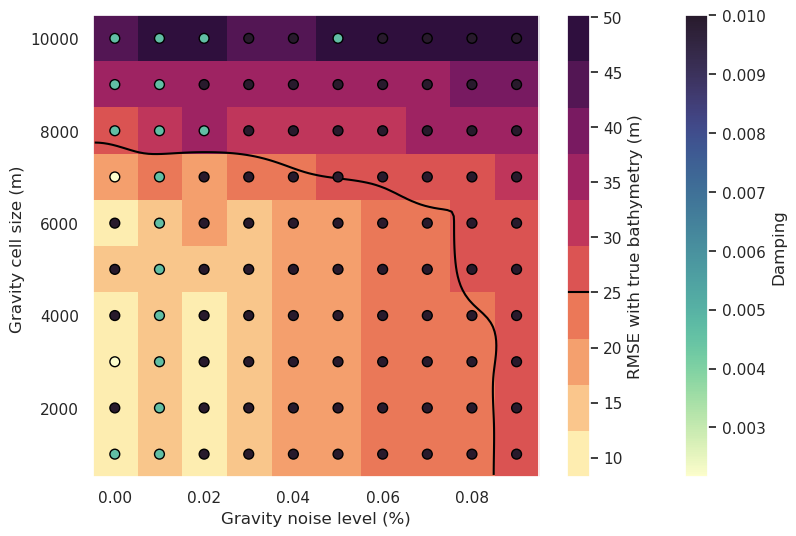

In [3]:
fig = plotting.plot_noise_cellsize_ensemble(
    df,
    background="RMSE",
    background_title="RMSE with true bathymetry (m)",
    # background="Score",
    # background_title="Gravity CV score",
    # background="Damping",
    # background_title="Damping",
    # background="Eq source score",
    # background_title="Eq source score",
    # background_color_log = True,
    background_robust=True,
    # points_color=df.RMSE,
    points_color=df.Damping,
    # points_color=df["Eq source score"],
    # points_color=df.Score,
    # points_size=df.RMSE,
    # points_size=df.Score,
    # points_scaling=80,
    # points_color_log=True,
    # points_robust=True,
    plot_contours=[25],
)

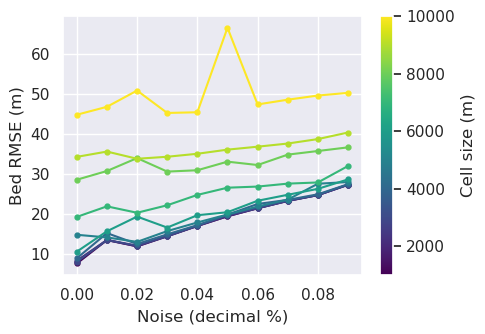

In [7]:
plotting.plot_ensemble_as_lines(
    df,
    x_col="noise",
    groupby_col="cell_size",
    x_label="Noise (decimal %)",
    cbar_label="Cell size (m)",
)

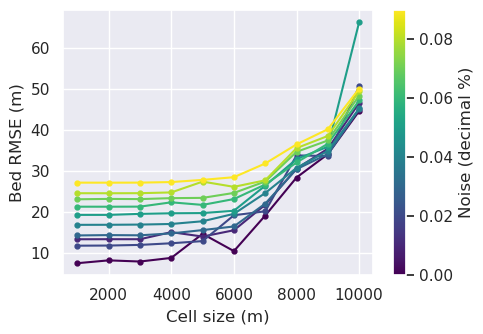

In [6]:
plotting.plot_ensemble_as_lines(
    df,
    x_col="cell_size",
    groupby_col="noise",
    x_label="Cell size (m)",
    cbar_label="Noise (decimal %)",
)

In [27]:
# # load best inversion results of each set of noise/sampling
# with open(f"{set_fname}_trial_{0}.pickle", 'rb') as f:
#     inversion_results = pickle.load(f)
# inversion_results

In [28]:
index = df[(df.noise == 0.08) & (df.cell_size == 8e3)].index[0]
choosen_result = inversion_results[index]
print(df.loc[index])
choosen_result[0]

noise                 0.080000
cell_size          8000.000000
Score                 0.664165
RMSE                 35.640234
Damping               0.010000
Eq source score       0.697781
Name: 87, dtype: float64


35.640234269248595

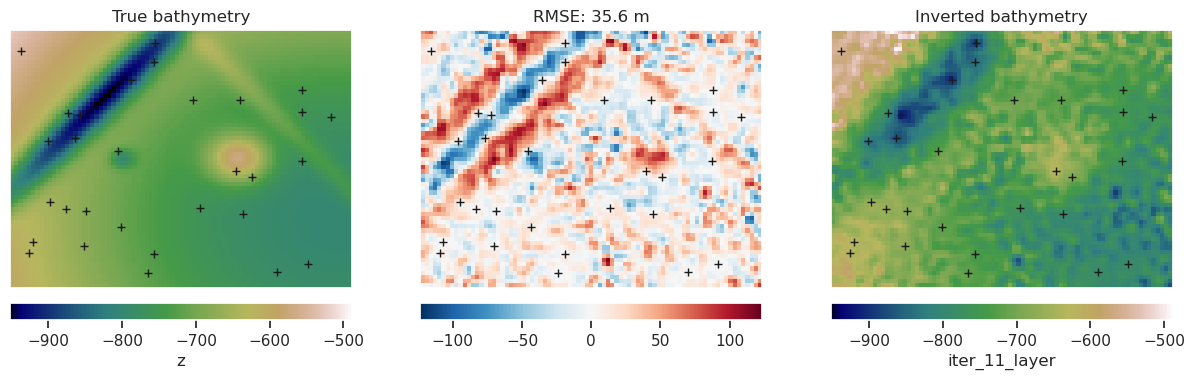

In [29]:
_ = inv.inversion_RMSE(
    results=choosen_result,
    true_surface=layer1,
    inversion_region=inversion_region,
    constraints=constraints,
    plot=True,
    plot_type="xarray",
    # points_style="+.2c",
    # robust=True,#False,
)